In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from scipy.spatial import distance
from sklearn.linear_model import Ridge
import statsmodels.api as sm
import seaborn as sns
from sklearn.metrics import mean_squared_error as mse
import holidays
import itertools
from scipy import stats
import warnings

ImportError: No module named holidays

## Загрузка данных

Загрузим агрегированные данные за 13 месяцев, с июня 2015 года до июня 2016 года включительно.

In [2]:
start_year, start_month = 2015, 6

data = []

for i in range(13):
    date = datetime(start_year, start_month, 1) + relativedelta(months=i)
    data.append(pd.read_csv('taxi/agregated/yellow_tripdata_{}-{:02d}_agr.csv'.format(date.year, date.month), parse_dates=True, index_col=0))
    
data = pd.concat(data)

Из всех регионов, возьмем только те, которые были отобраны на второй неделе (102 региона).

In [3]:
may_2016 = pd.read_csv('taxi/agregated/yellow_tripdata_2016-05_agr.csv')
means = may_2016.mean(axis=0)
means = means[means >= 5]
data = data[means.index.values]
data.shape

(9504, 102)

In [4]:
data.tail()

1075  1076  1077  1125  1126  1127  1128  1129  1130  \
date_hour                                                                   
2016-06-30 19:00:00   116   190   135   132   395   308   401   336   496   
2016-06-30 20:00:00   104   142   149   141   333   368   390   385   560   
2016-06-30 21:00:00   151   162   145   135   359   422   460   541   672   
2016-06-30 22:00:00   106   168   103   125   317   476   405   508   578   
2016-06-30 23:00:00    85   130    86   113   256   428   483   531   631   

                     1131  ...   1630  1684  1733  1734  1783  2068  2069  \
date_hour                  ...                                              
2016-06-30 19:00:00   260  ...      2    44     4   297   311   104     9   
2016-06-30 20:00:00   247  ...      1    27     7   288   344   103    24   
2016-06-30 21:00:00   259  ...      2    21     9   287   307   185     9   
2016-06-30 22:00:00   259  ...      3    19     5   358   387   169    12   
2016-06-30 23:00:00   210  ...      9     0     7   323   110   147    38   

                     2118  2119  2168  
date_hour                              
2016-06-30 19:00:00   142    96     1  
2016-06-30 20:00:00   209   145     0  
2016-06-30 21:00:00   213   142     1  
2016-06-30 22:00:00   206   146     0  
2016-06-30 23:00:00   173   119     0  

[5 rows x 102 columns]

In [5]:
all_regions = data.columns.values

## Стандартизация столбцов

Для каждого столбца вычтем выборочное среднее и поделим на выборочную дисперсию. 

In [6]:
data_stand = (data[:'2016-04-30'] - data[:'2016-04-30'].mean())/data[:'2016-04-30'].std()

## Кластеризация по географическим зонам

Сделаем иерархическую кластеризацию. Инструмент для визуализации результатов иерархической кластеризации, называется дендрограммой (dendrogram) и позволяет обрабатывать многомерные массивы данных.

In [7]:
X = data_stand.T.values
Z = linkage(X, 'ward')

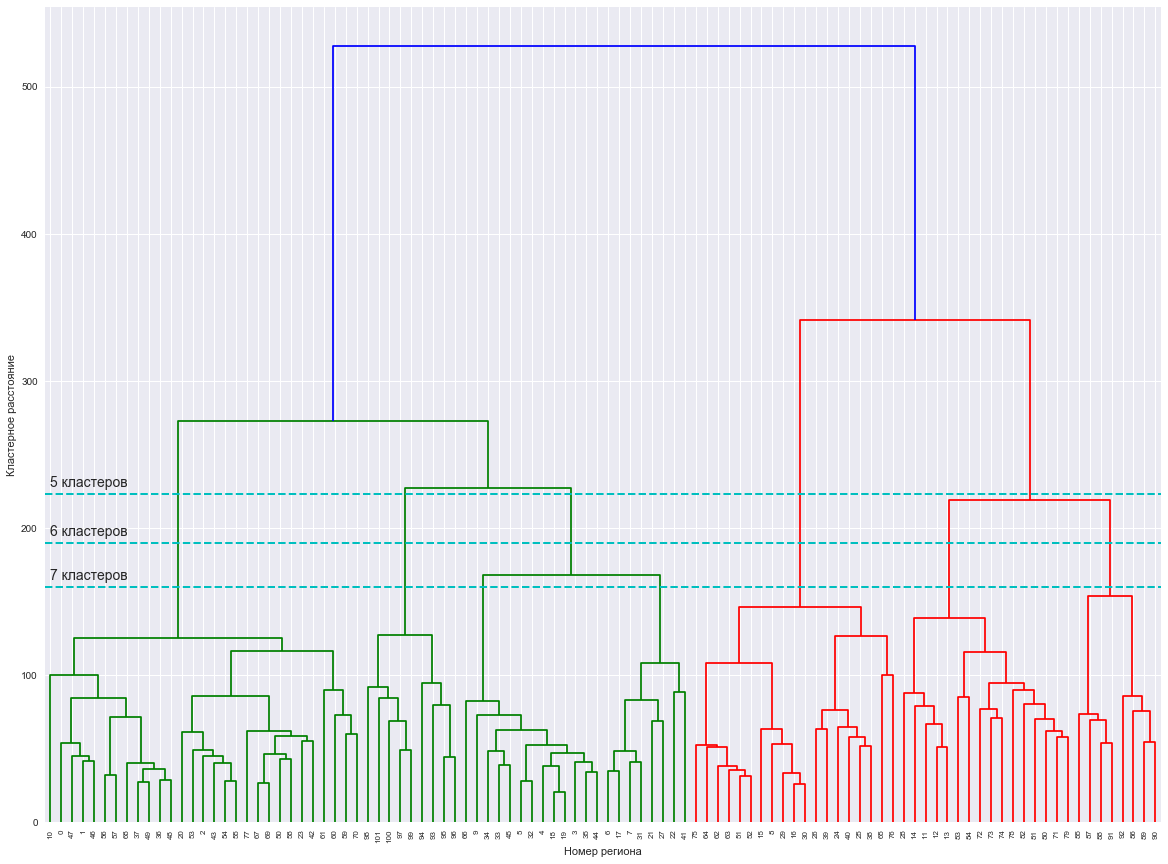

In [8]:
fig, ax = plt.subplots(figsize = (20, 15))
bounds = ax.get_xbound()
dendrogram(Z, leaf_rotation=90., leaf_font_size=8.)
ax.axhline(y=160, xmin=0, xmax=1, linestyle='--', linewidth=2, color='c')
ax.axhline(y=190, xmin=0, xmax=1, linestyle='--', linewidth=2, color='c')
ax.axhline(y=223, xmin=0, xmax=1, linestyle='--', linewidth=2, color='c')
ax.text(5, 165, u'7 кластеров', fontsize=14)
ax.text(5, 195, u'6 кластеров', fontsize=14)
ax.text(5, 228, u'5 кластеров', fontsize=14)
plt.xlabel(u'Номер региона')
plt.ylabel(u'Кластерное расстояние')
plt.show()

Чтение дендрограммы происходит снизу вверх. Ось y в дендрограмме указывает не только момент объединения двух кластеров в ходе работы алгоритма агломеративной кластеризации. Длина каждой ветви показывает, насколько далеко друг от друга находятся объединенные кластеры. Двигаясь снизу вверх, длина ветвей на дендрограмме у 6 кластеров являются длиннее, чем у всех предыдущих, этот факт, указывает на то, что переход от 6 кластеров к 5 сопровождался объединением некоторых сильно удаленных друг от друга точек. Поэтому выбиру за основу  - 6 кластеров.

После того как мы выбрали число кластеров k=6, воспользуемся одним из самых простых и наиболее часто используемых алгоритмов кластеризации KMeans. Это удобно т.к. алгоритм k-средних отбирает точки, которые будут представлять центры кластеров. Именно для этих центров кластеров (регионов) мы и будем подбирать модели ARIMA.

In [9]:
k = 6
kmeans = KMeans(n_clusters=6, random_state=1)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

Присвоим всем столбцам, соответствующие им метки.

In [10]:
data.columns = [kmeans.labels_, data.columns.values]
data_stand.columns = [kmeans.labels_, data_stand.columns.values]

## Выбор наиболее типичного ряда

Наиболее типичным рядом каждого кластера будем считать ряд, который имеет минимальное евклидово расстояние с центром данного кластера.

In [11]:
cluster_centers = []

for i in range(k):
    ind = ''
    for j in range(data_stand[i].shape[1]):
        if (j == 0):
            best_dist = distance.euclidean(data_stand[i].iloc[:,j].values, kmeans.cluster_centers_[i])
            continue
        euc_dist = distance.euclidean(data_stand[i].iloc[:,j].values, kmeans.cluster_centers_[i])    
        if (euc_dist < best_dist):
            best_dist = euc_dist
            ind = data[i].columns[j]
    cluster_centers.append(ind)

In [12]:
for i in range(k):
    print "{0} - {1}".format(i+1, cluster_centers[i])

1 - 1734
2 - 1326
3 - 1387
4 - 1482
5 - 1333
6 - 1180


Отобразим графически полученные кластеры (данные за июнь 2015). Толстой линией выделен наиболее типичный для данного кластера временной ряд.

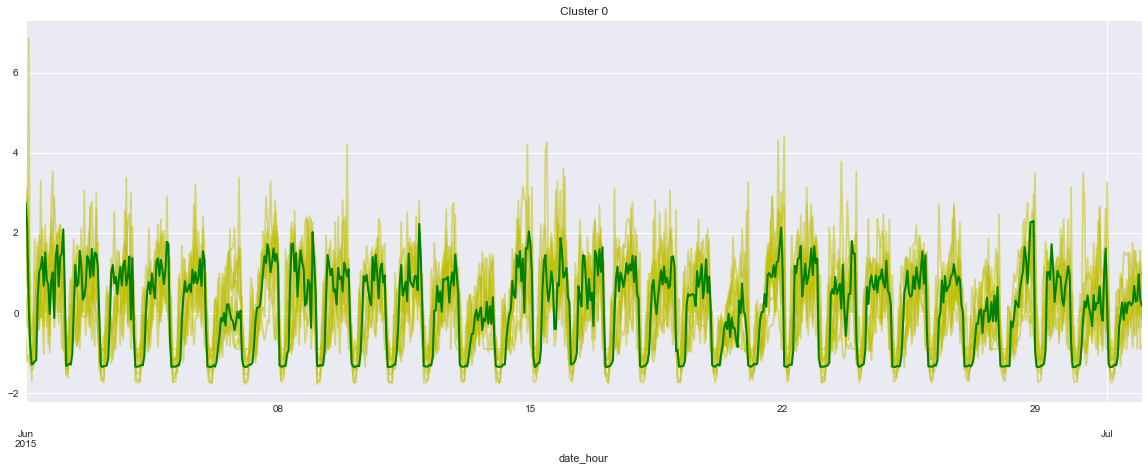

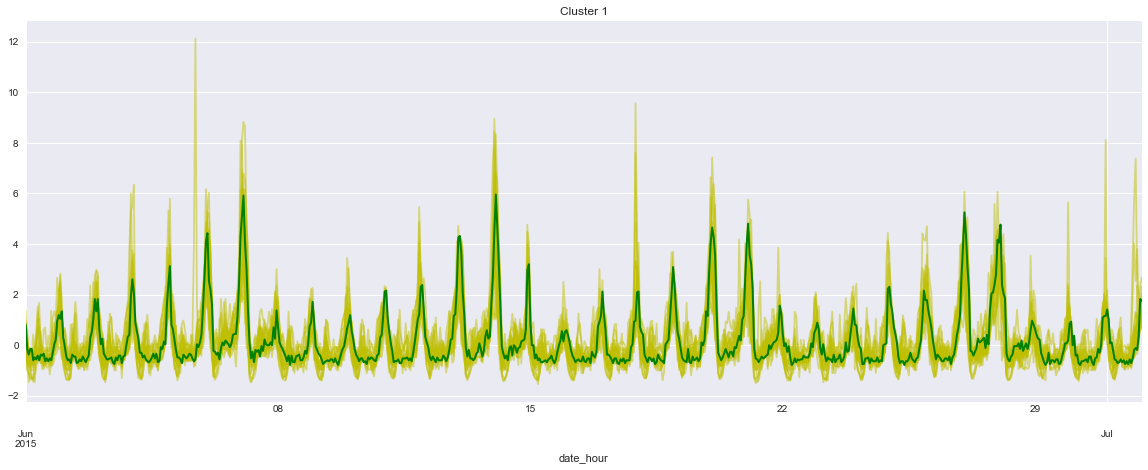

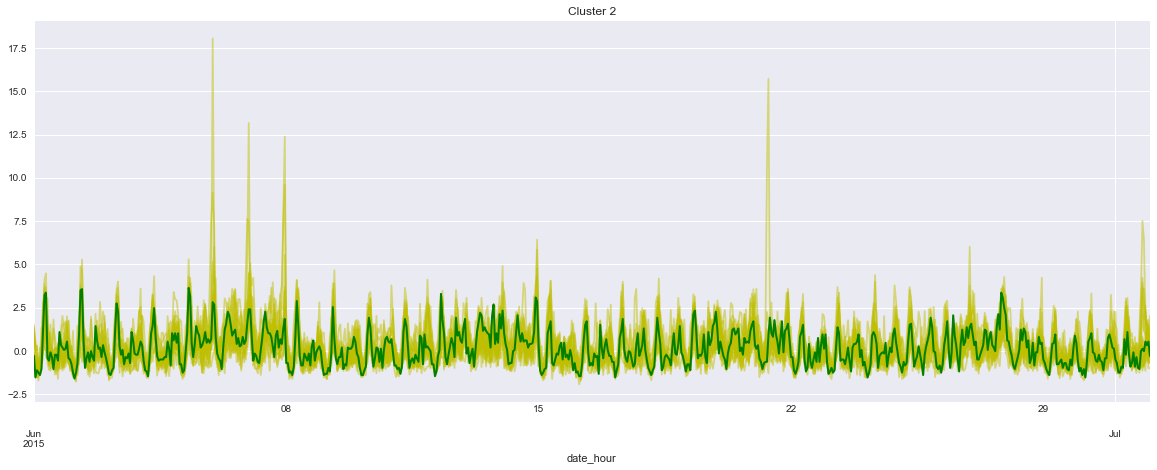

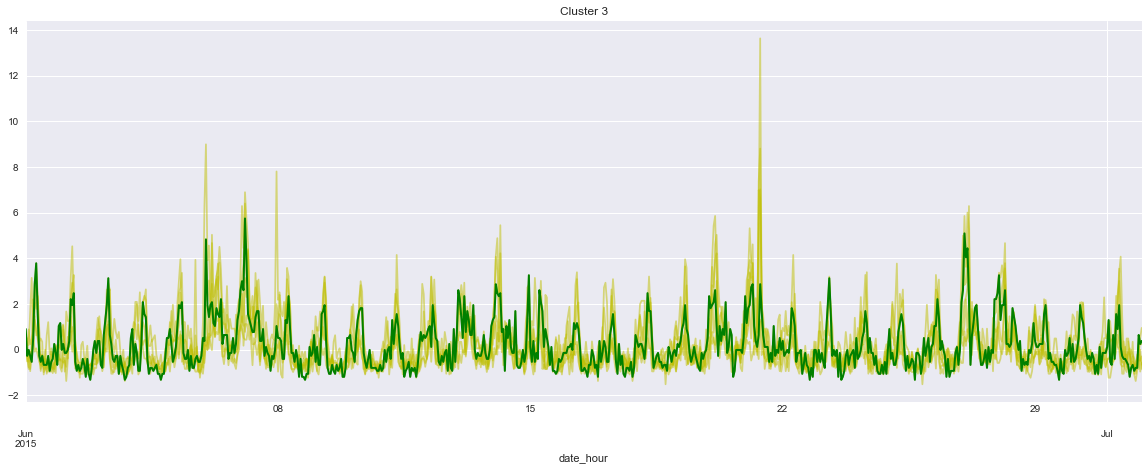

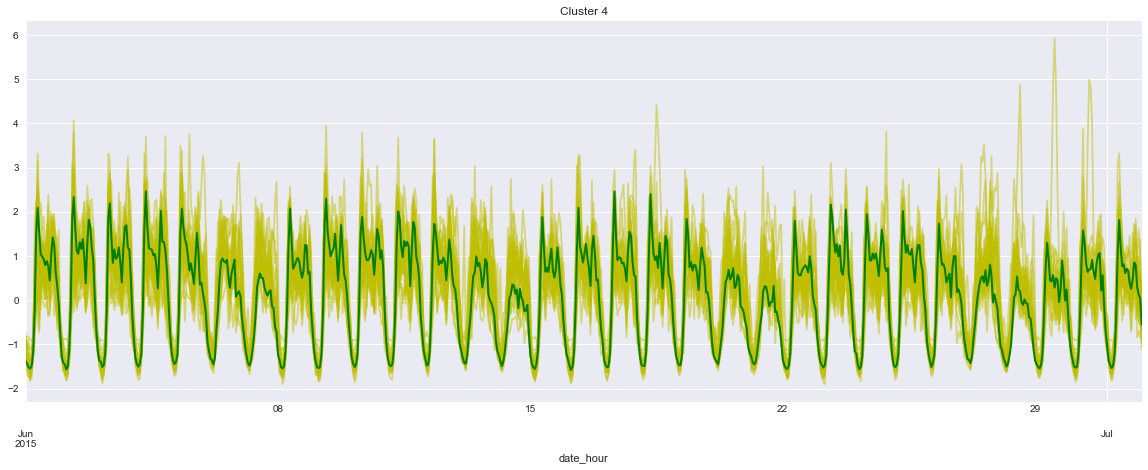

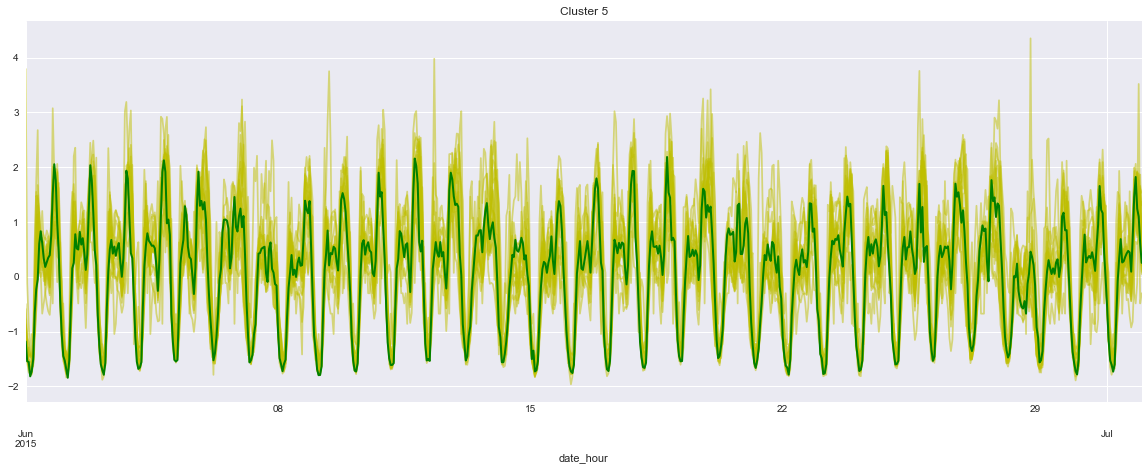

In [13]:
star_date = '2015-06-01'
end_date = '2015-07-01'
for i in range(k):
    data_stand[i][star_date:end_date].plot(color='y', alpha=0.5, figsize=(20,7))
    data_stand[i][cluster_centers[i]][star_date:end_date].plot(color='g', alpha=1, linewidth=2)
    plt.legend().set_visible(False)
    plt.title('Cluster {}'.format(str(i)))
    plt.show()

## Подбор регрессионных признаков

В качестве регрессионных признаков возьмем день недели, оффициальные праздники штата Нью-Йорк, гармоники по недельному периоду сезонности, скользящее среднее (трендовый индикатор), а так же скользящий минимум и максимум. По тестовой выборке подберем параметры для этих регрессионных признаков.

In [14]:
t = data.shape[0]
index = int(data.shape[0]*0.7)

reg = Ridge()

ny_holidays = holidays.UnitedStates(state='NY')
hdays = []
for i in range(data.shape[0]):
    hdays.append(data.index.date[i] in ny_holidays)
hdays = np.array(hdays)

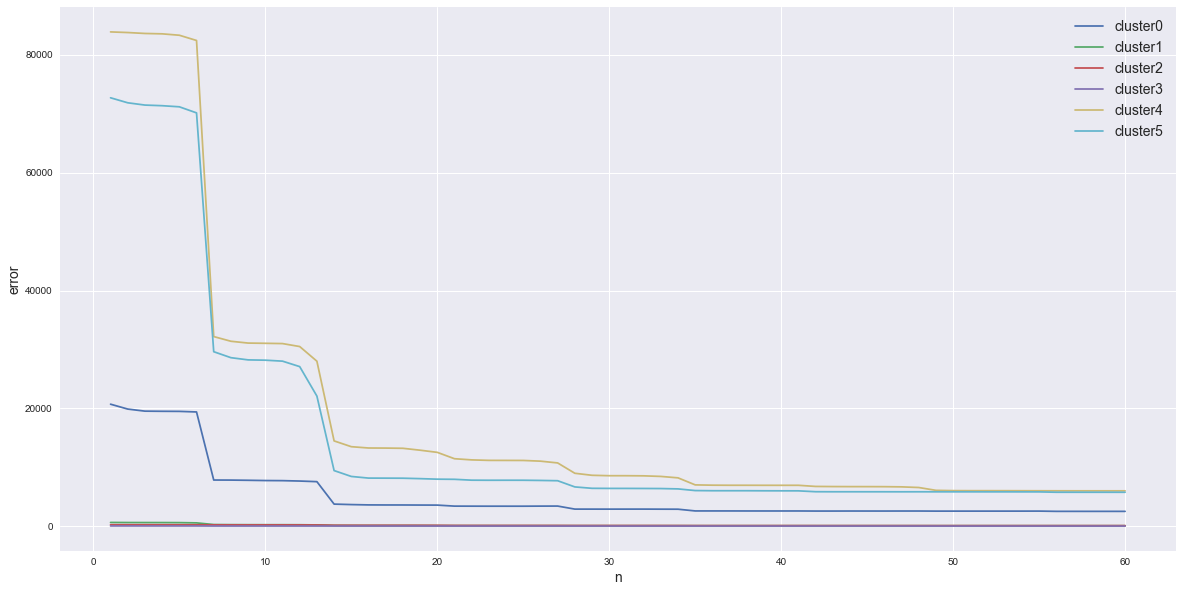

In [15]:
n = range(1, 61) # параметр K гармоники
result = np.arange(len(n))
res = pd.DataFrame(index=n)
                  
for num in range(k):
    y = data[num][cluster_centers[num]].values
    y_train = y[:index]
    y_test = y[index:]
    X = pd.DataFrame()
    X['weekday'] = data.index.weekday.values
    X['holiday'] = hdays
    X['holiday'] = X.holiday.astype(int)

    for i, j in enumerate(n):
        X['ws' + str(j)] = np.sin(np.arange(1,t+1) * 2.0 * np.pi * j / 168.0)
        X['wc' + str(j)] = np.cos(np.arange(1,t+1) * 2.0 * np.pi * j / 168.0)

        X_train = X[:index]
        X_test = X[index:]

        reg.fit(X_train, y_train)
        predicted = reg.predict(X_test)

        result[i] = mse(y_test, predicted)
            
    res['cluster' + str(num)] = result

plt.figure(figsize=(20,10))
plt.plot(res)
plt.ylabel('error', fontsize=14)
plt.xlabel('n', fontsize=14)
plt.legend(res.columns, fontsize=14)
plt.show()

Как видно из графика, среднеквадратическая ошибка уменьшается с увеличением параметра гармоник K. Для наиболее типичных временных рядов каждого кластера выберем оптимальный параметр K равным 50, т.к. при данном значение среднеквадратическая ошибка сходится для всех временных рядов. Рассчитаем остатки и сохраним их значения, т.к. они понадобятся нам для построения моделей ARIMA.

In [16]:
K = 50
X = pd.DataFrame(index = data.index)
X['weekday'] = data.index.weekday.values

X['holiday'] = hdays
X['holiday'] = X['holiday'].astype(int)

for i in range(1, K+1):
    X['ws' + str(i)] = np.sin(np.arange(1,t+1) * 2.0 * np.pi * i / 168.0)
    X['wc' + str(i)] = np.cos(np.arange(1,t+1) * 2.0 * np.pi * i / 168.0)

resid = pd.DataFrame(index = data.index)

for i in range(k):
    y = data[i][cluster_centers[i]]
    reg.fit(X[:'2016-04-30'], y[:'2016-04-30'])
    resid['res' + str(i)] = y - reg.predict(X)

## Дифференцирование

Сделаем сезонное дифференцирование. 

In [17]:
for i in range(k):
    resid['res' + str(i)+ '_24'] = resid['res' + str(i)] - resid['res' + str(i)].shift(24)

## Кластер №0

Рассчитаем критерий Дики-Фуллера для остатков.

In [18]:
print 'Критерий Дики-Фуллера: p = {}'.format(sm.tsa.stattools.adfuller(resid.res0[:'2016-04-30'])[1])
print 'Критерий Дики-Фуллера (с сезонным дифференцированием): p = {}'.format(sm.tsa.stattools.adfuller(resid.res0_24[24:][:'2016-04-30'])[1])

Критерий Дики-Фуллера: p = 1.84218558906e-15
Критерий Дики-Фуллера (с сезонным дифференцированием): p = 4.69009611295e-30


Сделаем STL-декомпозицию остатков.

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


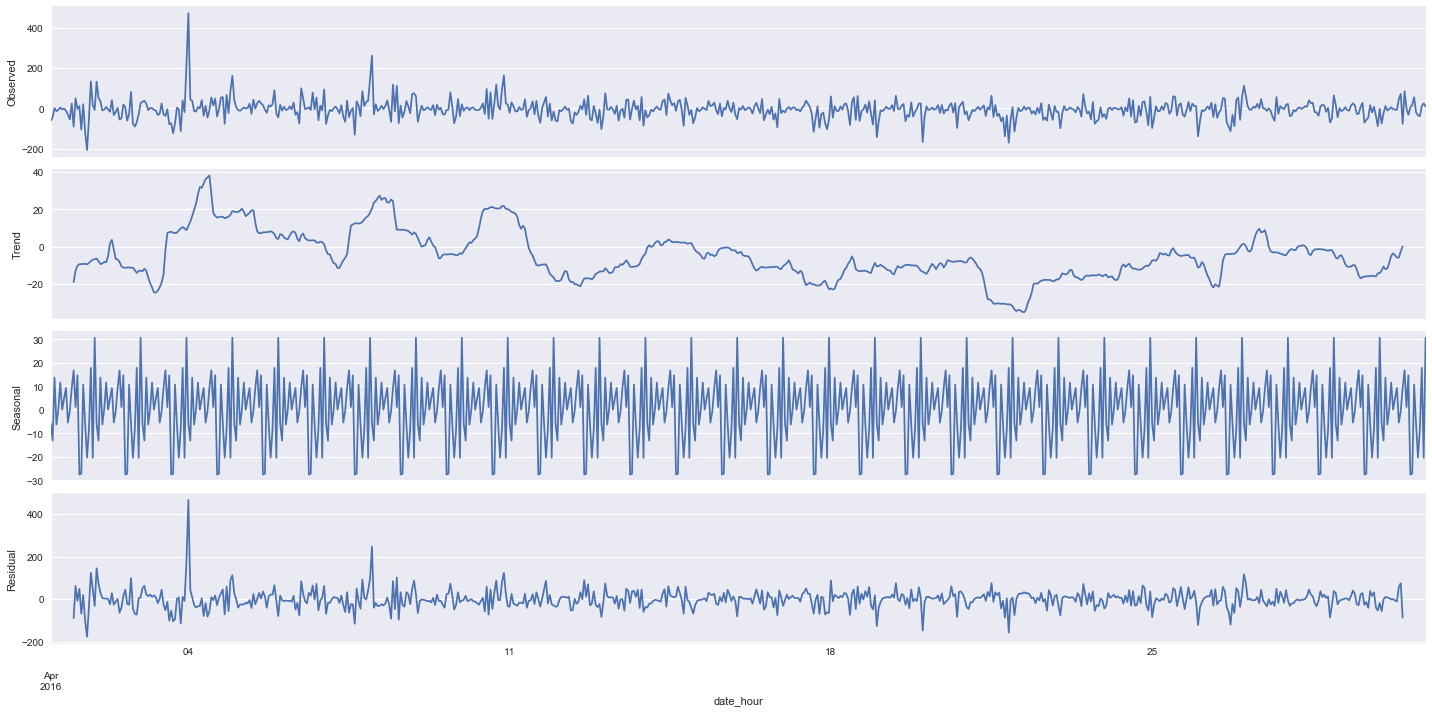

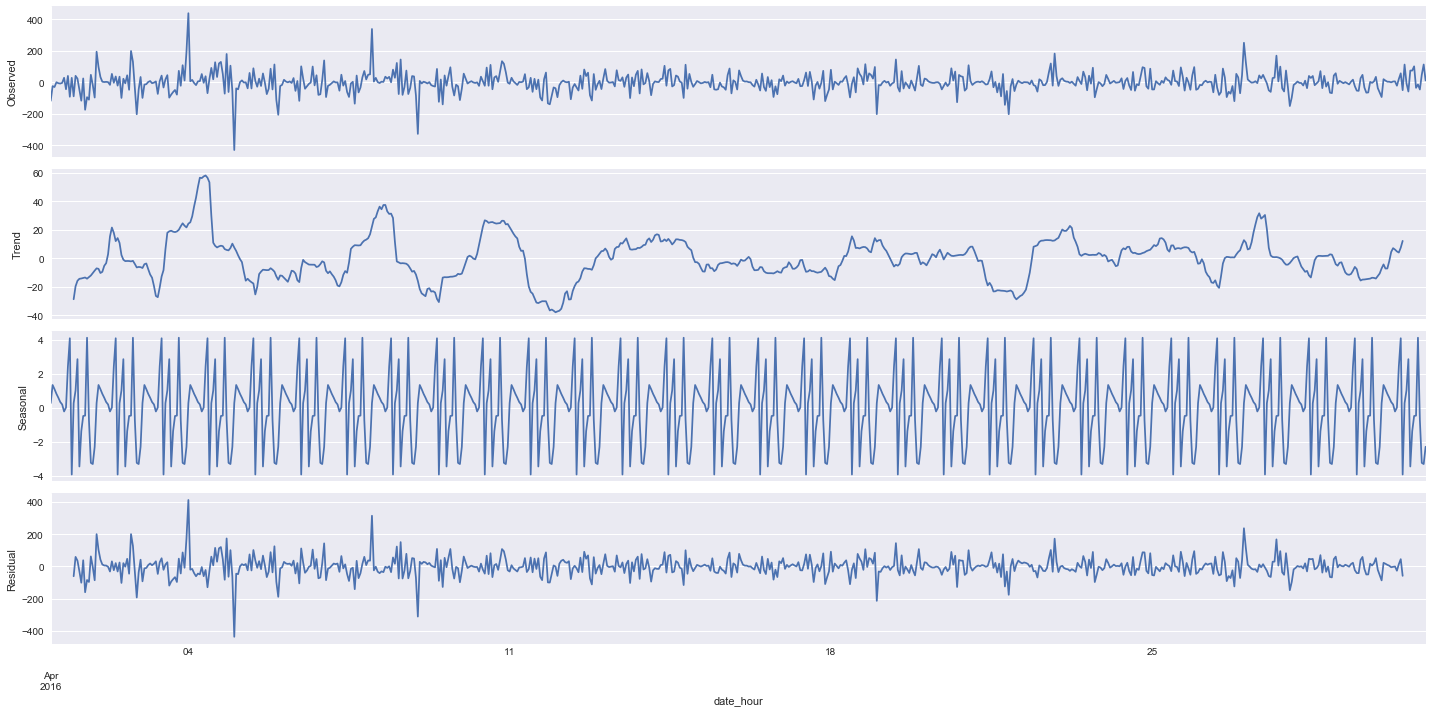

In [19]:
%pylab inline
plt.figure(figsize(20,10))
sm.tsa.seasonal_decompose(resid.res0['2016-04-01':'2016-04-30']).plot()  
sm.tsa.seasonal_decompose(resid.res0_24['2016-04-01':'2016-04-30']).plot()
pylab.show()

Построим ACF и PACF полученного ряда продифференцированных остатков.

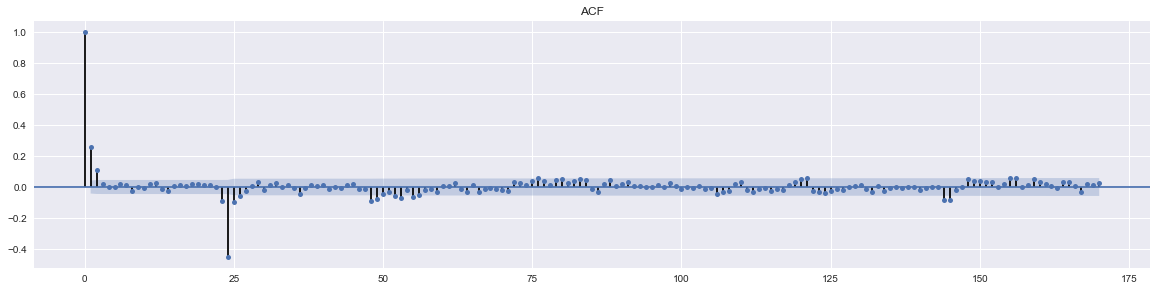

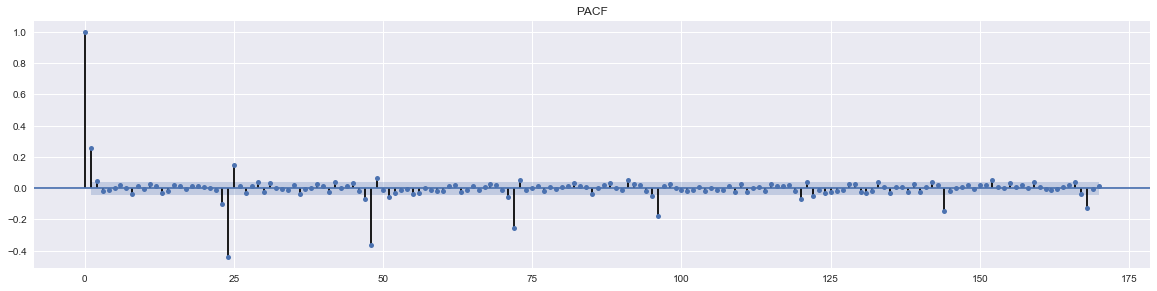

In [20]:
plt.figure(figsize(20,10))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(resid.res0_24['2016-02-01':'2016-04-30'].values.squeeze(), lags = 170, ax=ax, title = 'ACF')
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(resid.res0_24['2016-02-01':'2016-04-30'].values.squeeze(), lags = 170, ax=ax,title = 'PACF')
pylab.show()

Создадим метод для построения модели ARIMA.

In [21]:
def get_arima(endog, params, d, D, s):

    results = []
    best_aic = float("inf")
    warnings.filterwarnings('ignore')

    for param in params:
        p, q, P, Q = param
        try:
            model = sm.tsa.statespace.SARIMAX(endog, order=(p, d, q), seasonal_order=(P, D, Q, s), simple_differencing=True).fit(disp=-1)
        except ValueError:
            continue
        except LinAlgError:
            continue
            
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])    

    warnings.filterwarnings('default')
    
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    print(result_table.sort_values(by = 'aic', ascending=True).head())        
    
    return best_model

Зададим параметры модели.

In [22]:
ps = range(1, 3)
d = 0
qs = range(1, 3)

Ps = range(1, 3)
D = 1
Qs = range(1, 3)

s = 24

params = list(itertools.product(ps, qs, Ps, Qs))
print len(params)

16


Подберем лучшие гиперпараметры модели ARIMA для типичного ряда кластера №0. 

In [23]:
best_model = get_arima(resid.res0['2016-01-01':'2016-04-30'], params, d, D, s)

      parameters           aic
11  (2, 1, 2, 2)  31441.580232
9   (2, 1, 1, 2)  31442.068273
1   (1, 1, 1, 2)  31445.120211
3   (1, 1, 2, 2)  31446.941710
8   (2, 1, 1, 1)  31448.860696


Посмотрим на график остатков.

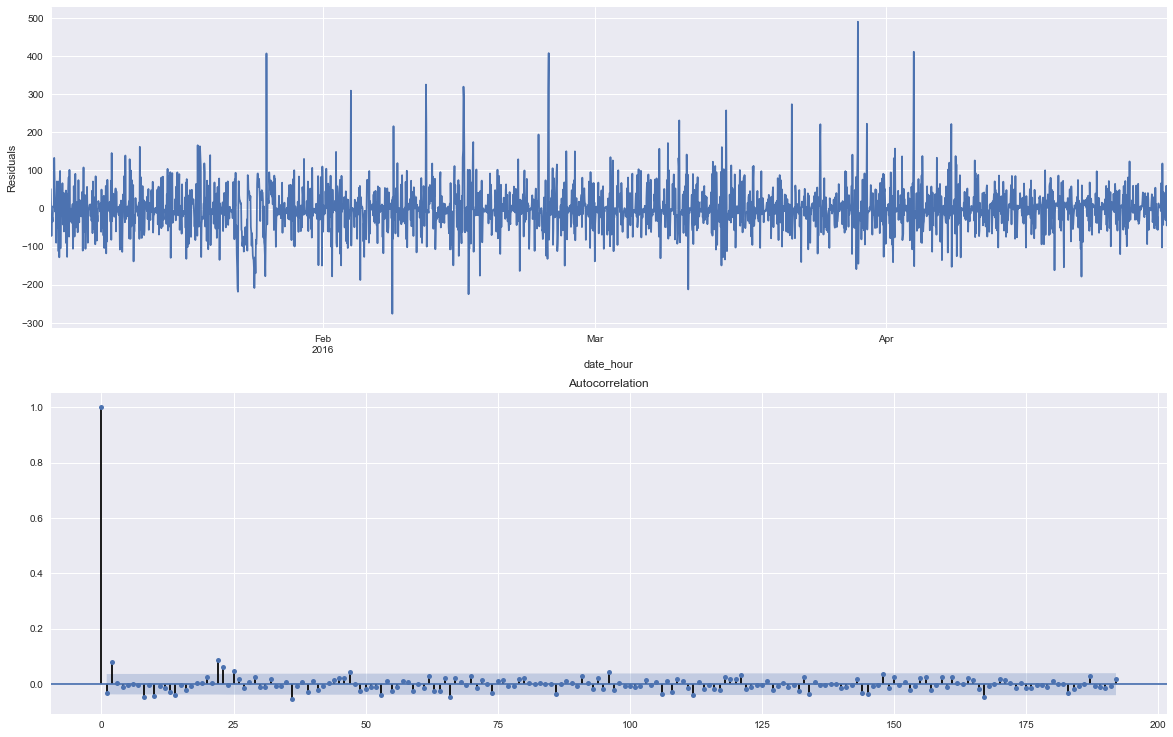

Критерий Стьюдента: p=0.738470
Критерий Дики-Фуллера: p=0.000000


In [24]:
f, (ax1, ax2) = plt.subplots(2, figsize=(20,13))
ax1 = plt.subplot(211)
best_model.resid[24:].plot()
plt.ylabel('Residuals')
ax2 = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[24:].values.squeeze(), lags=192, ax=ax2)
plt.show()

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[24:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[24:])[1])

## Кластер №1

Рассчитаем критерий Дики-Фуллера для остатков.

In [25]:
print 'Критерий Дики-Фуллера: p = {}'.format(sm.tsa.stattools.adfuller(resid.res1[:'2016-04-30'])[1])
print 'Критерий Дики-Фуллера (с сезонным дифференцированием): p = {}'.format(sm.tsa.stattools.adfuller(resid.res1_24[24:][:'2016-04-30'])[1])

Критерий Дики-Фуллера: p = 5.84571270617e-21
Критерий Дики-Фуллера (с сезонным дифференцированием): p = 0.0


Сделаем STL-декомпозицию остатков.

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


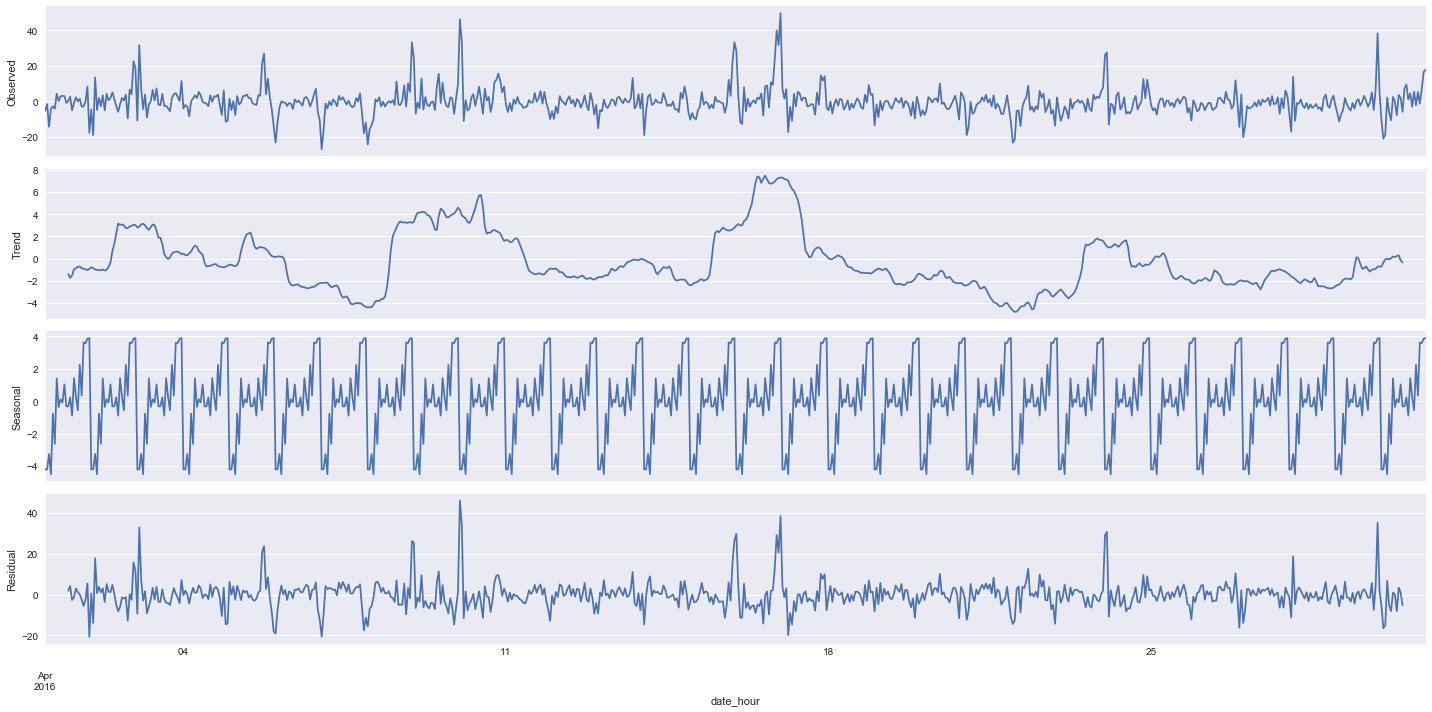

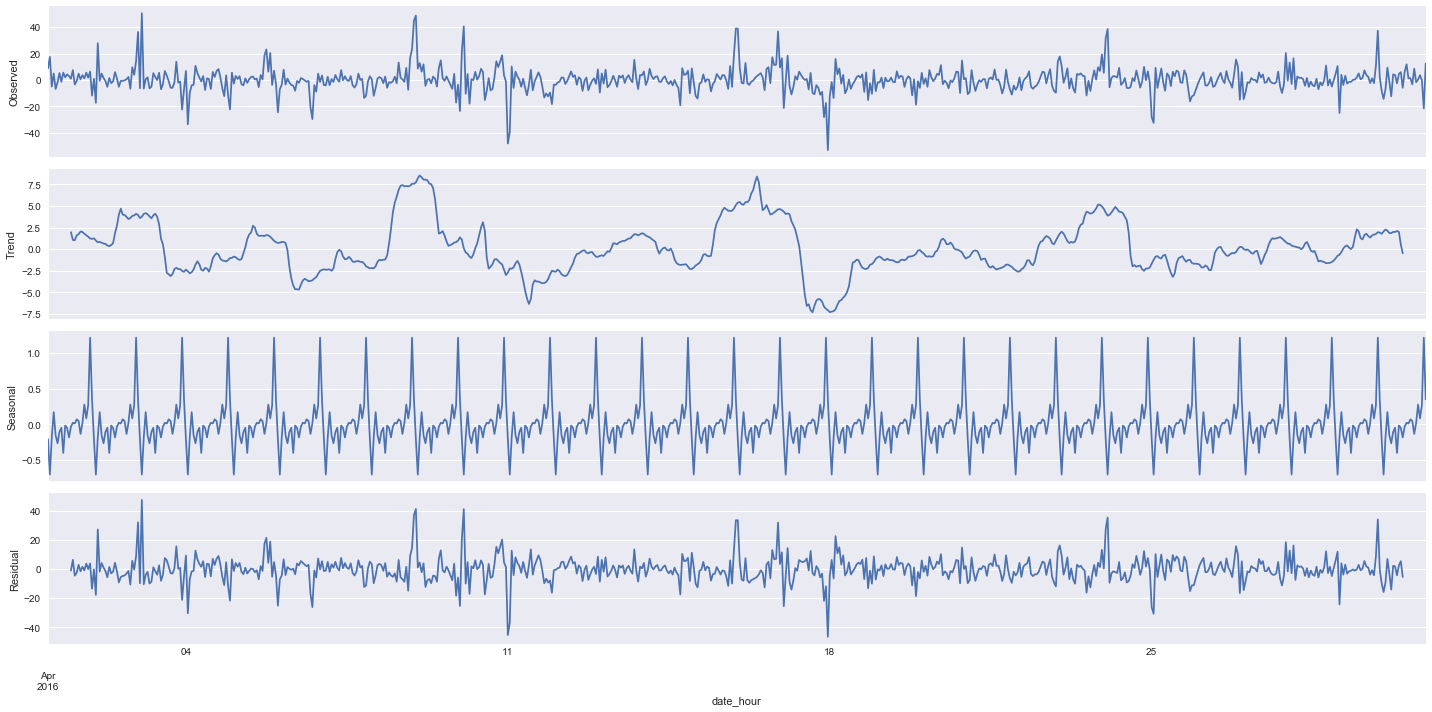

In [26]:
%pylab inline
plt.figure(figsize(20,10))
sm.tsa.seasonal_decompose(resid.res1['2016-04-01':'2016-04-30']).plot()  
sm.tsa.seasonal_decompose(resid.res1_24['2016-04-01':'2016-04-30']).plot()
pylab.show()

Построим ACF и PACF полученного ряда продифференцированных остатков.

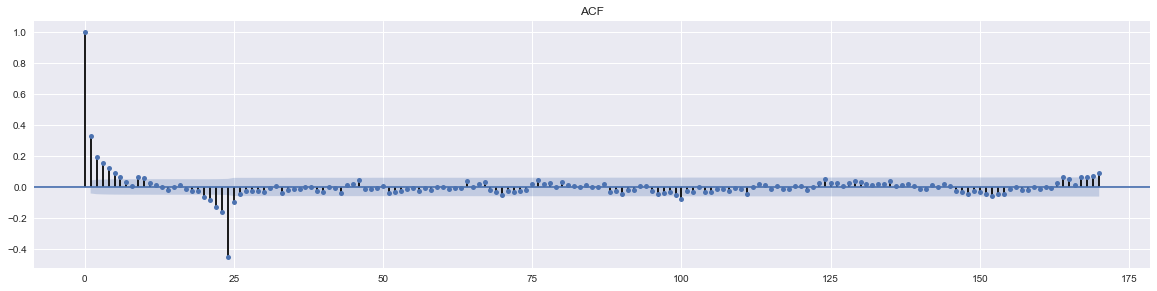

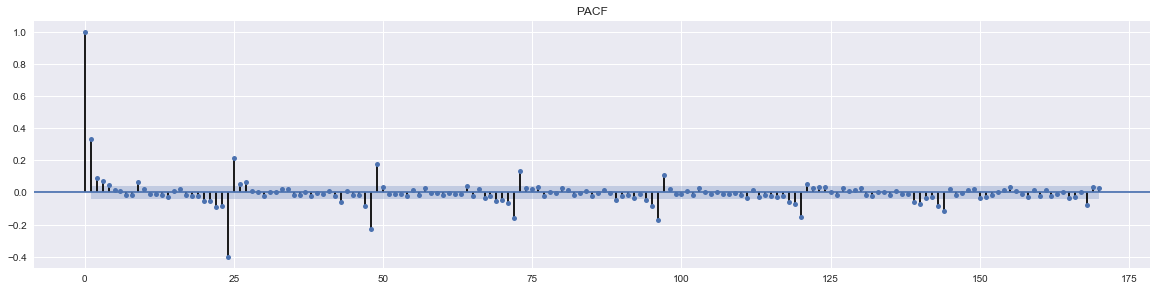

In [27]:
plt.figure(figsize(20,10))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(resid.res1_24['2016-02-01':'2016-04-30'].values.squeeze(), lags = 170, ax=ax, title = 'ACF')
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(resid.res1_24['2016-02-01':'2016-04-30'].values.squeeze(), lags = 170, ax=ax,title = 'PACF')
pylab.show()

In [28]:
ps = range(1, 3)
d = 0
qs = range(1, 3)

Ps = range(1, 3)
D = 1
Qs = range(1, 3)

s = 24

params = list(itertools.product(ps, qs, Ps, Qs))
print len(params)

16


Подберем лучшие гиперпараметры модели ARIMA для типичного ряда кластера №1. 

In [29]:
best_model = get_arima(resid.res1['2016-01-01':'2016-04-30'], params, d, D, s)

      parameters           aic
14  (2, 2, 2, 1)  20632.069481
2   (1, 1, 2, 1)  20632.070977
6   (1, 2, 2, 1)  20632.939351
10  (2, 1, 2, 1)  20633.215083
13  (2, 2, 1, 2)  20633.412672


Посмотрим на график остатков.

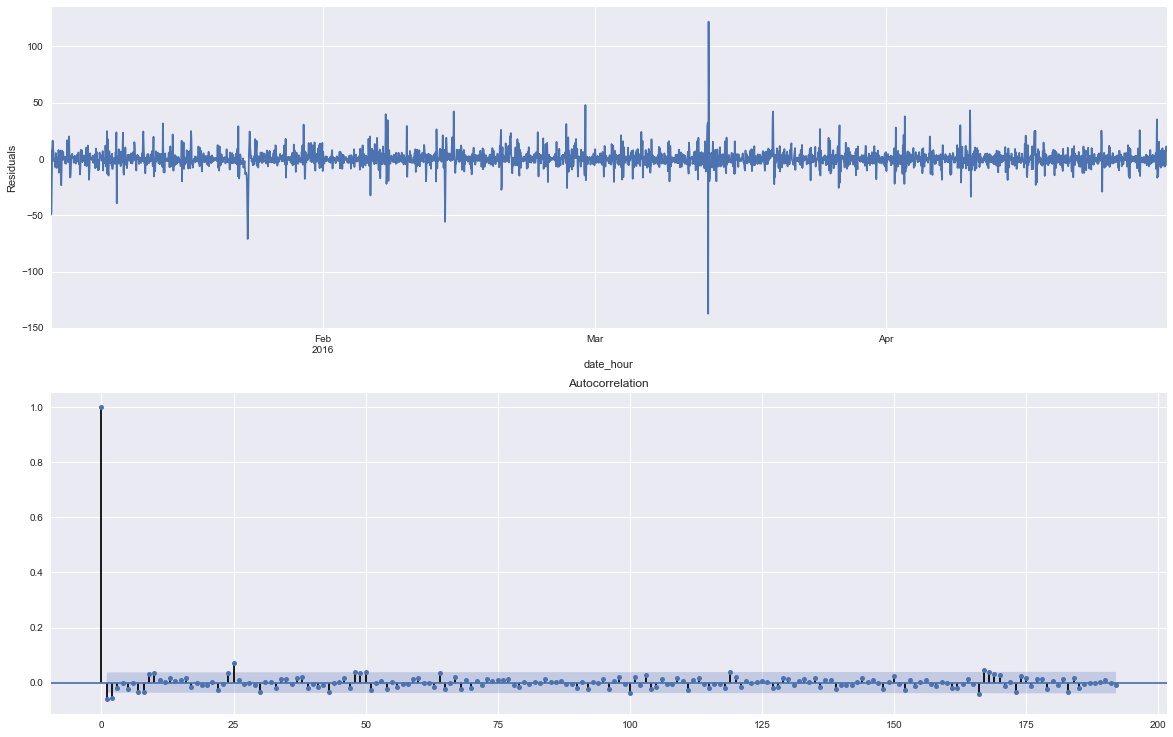

Критерий Стьюдента: p=0.278556
Критерий Дики-Фуллера: p=0.000000


In [30]:
f, (ax1, ax2) = plt.subplots(2, figsize=(20,13))
ax1 = plt.subplot(211)
best_model.resid[24:].plot()
plt.ylabel('Residuals')
ax2 = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[24:].values.squeeze(), lags=192, ax=ax2)
plt.show()

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[24:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[24:])[1])

## Кластер №2

Рассчитаем критерий Дики-Фуллера для остатков.

In [31]:
print 'Критерий Дики-Фуллера: p = {}'.format(sm.tsa.stattools.adfuller(resid.res2[:'2016-04-30'])[1])
print 'Критерий Дики-Фуллера (с сезонным дифференцированием): p = {}'.format(sm.tsa.stattools.adfuller(resid.res2_24[24:][:'2016-04-30'])[1])

Критерий Дики-Фуллера: p = 4.15226847383e-17
Критерий Дики-Фуллера (с сезонным дифференцированием): p = 0.0


Сделаем STL-декомпозицию остатков.

Populating the interactive namespace from numpy and matplotlib


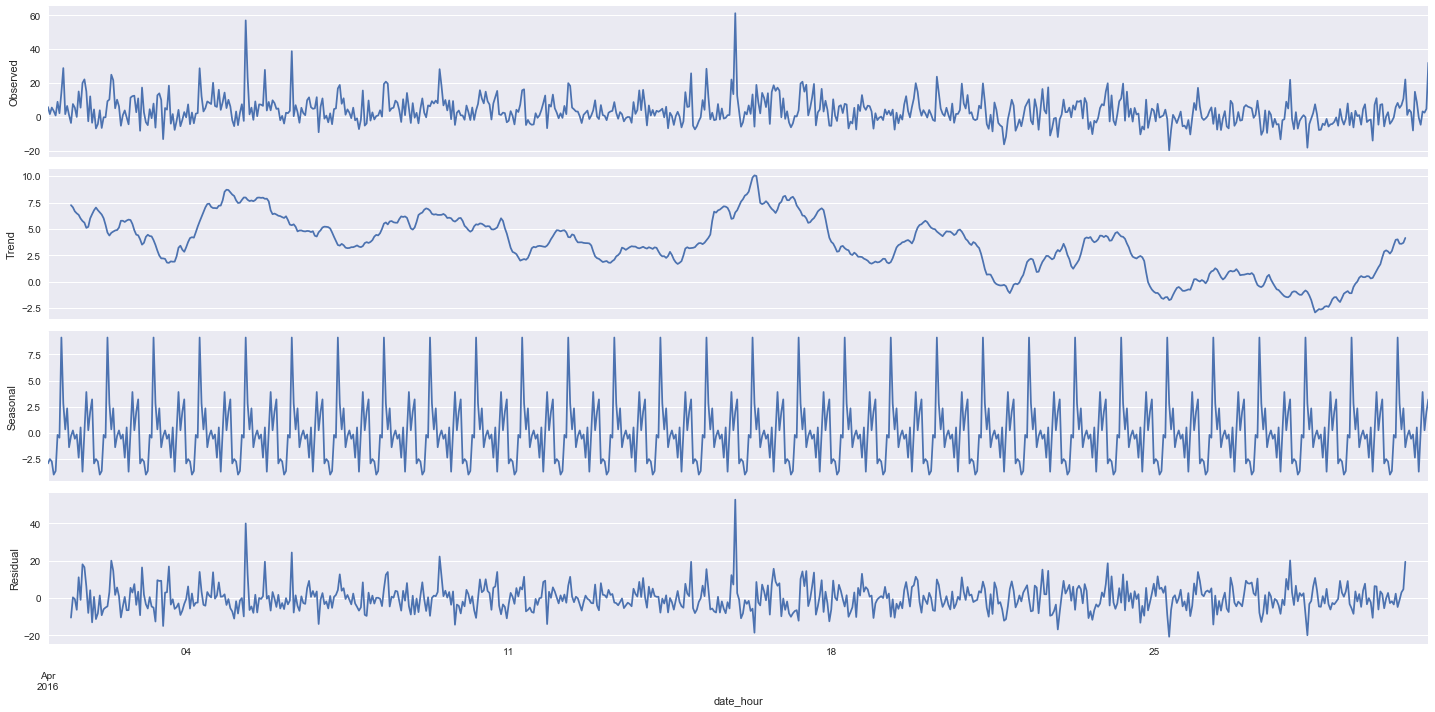

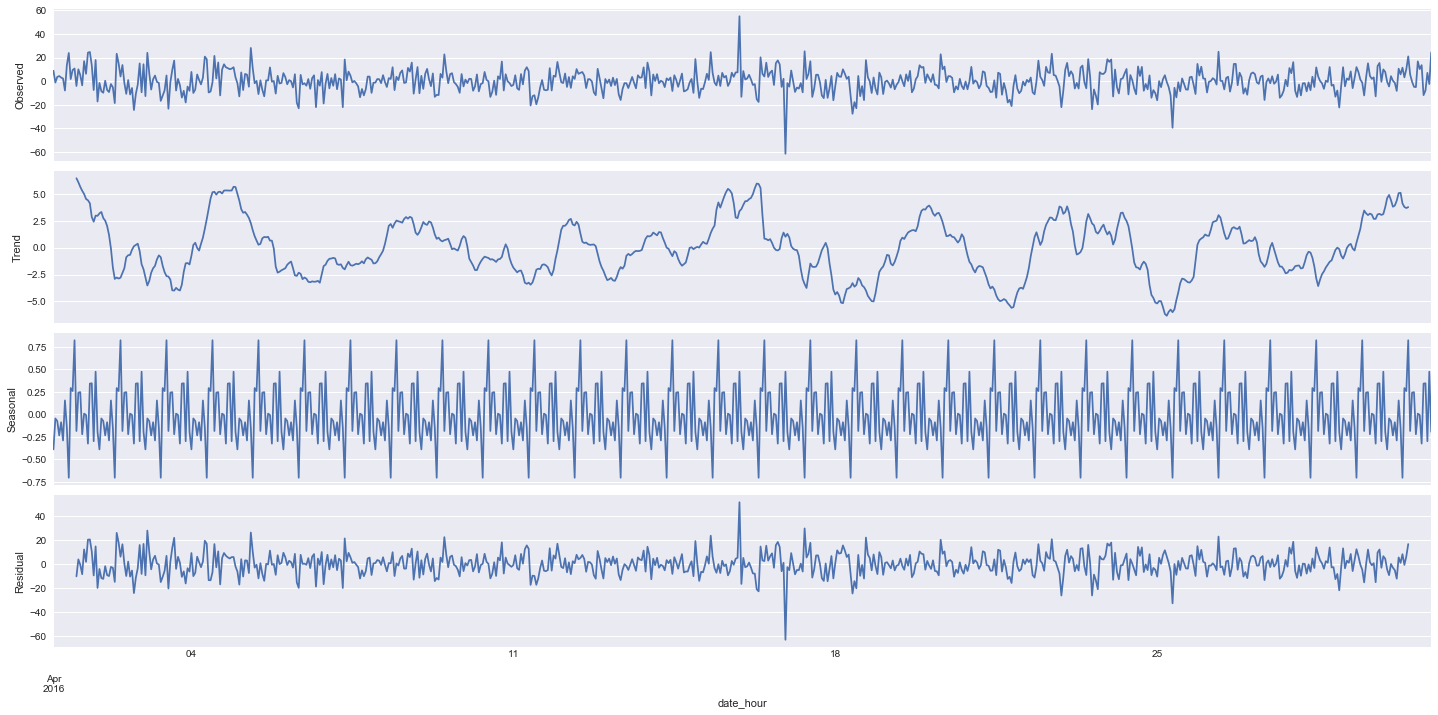

In [32]:
%pylab inline
plt.figure(figsize(20,10))
sm.tsa.seasonal_decompose(resid.res2['2016-04-01':'2016-04-30']).plot()  
sm.tsa.seasonal_decompose(resid.res2_24['2016-04-01':'2016-04-30']).plot()
pylab.show()

Построим ACF и PACF полученного ряда продифференцированных остатков.

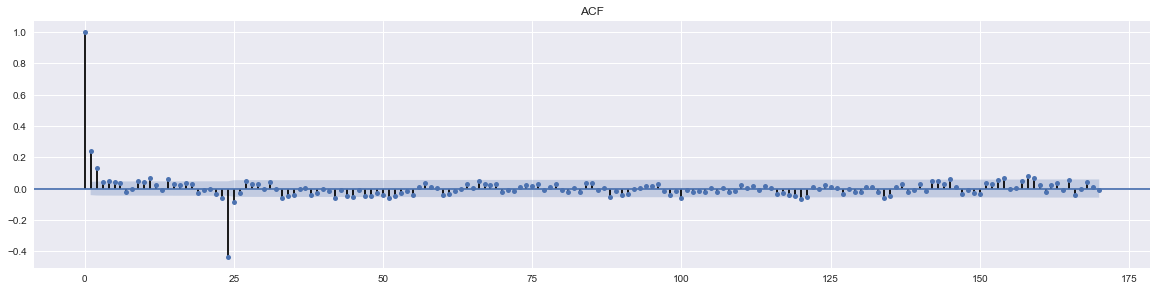

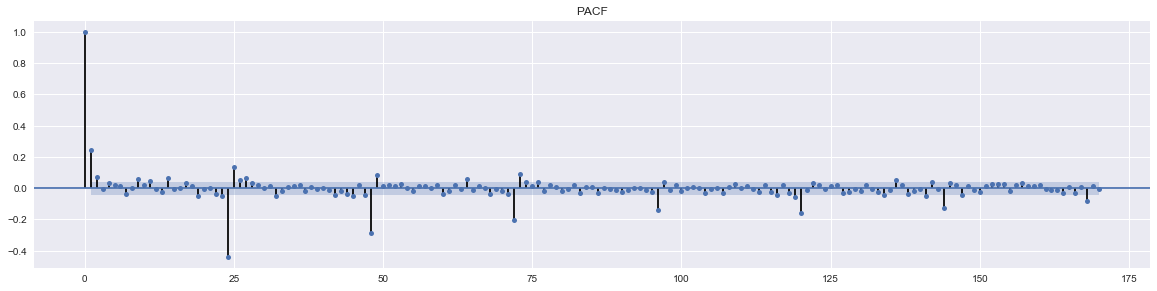

In [33]:
plt.figure(figsize(20,10))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(resid.res2_24['2016-02-01':'2016-04-30'].values.squeeze(), lags = 170, ax=ax, title = 'ACF')
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(resid.res2_24['2016-02-01':'2016-04-30'].values.squeeze(), lags = 170, ax=ax,title = 'PACF')
pylab.show()

In [34]:
ps = range(1, 3)
d = 0
qs = range(1, 3)

Ps = range(1, 3)
D = 1
Qs = range(1, 3)

s = 24

params = list(itertools.product(ps, qs, Ps, Qs))
print len(params)

16


Подберем лучшие гиперпараметры модели ARIMA для типичного ряда кластера №2. 

In [35]:
best_model = get_arima(resid.res2['2016-01-01':'2016-04-30'], params, d, D, s)

      parameters           aic
0   (1, 1, 1, 1)  20118.810630
11  (2, 1, 2, 2)  20119.288510
8   (2, 1, 1, 1)  20120.420716
4   (1, 2, 1, 1)  20120.615369
2   (1, 1, 2, 1)  20120.804566


Посмотрим на график остатков.

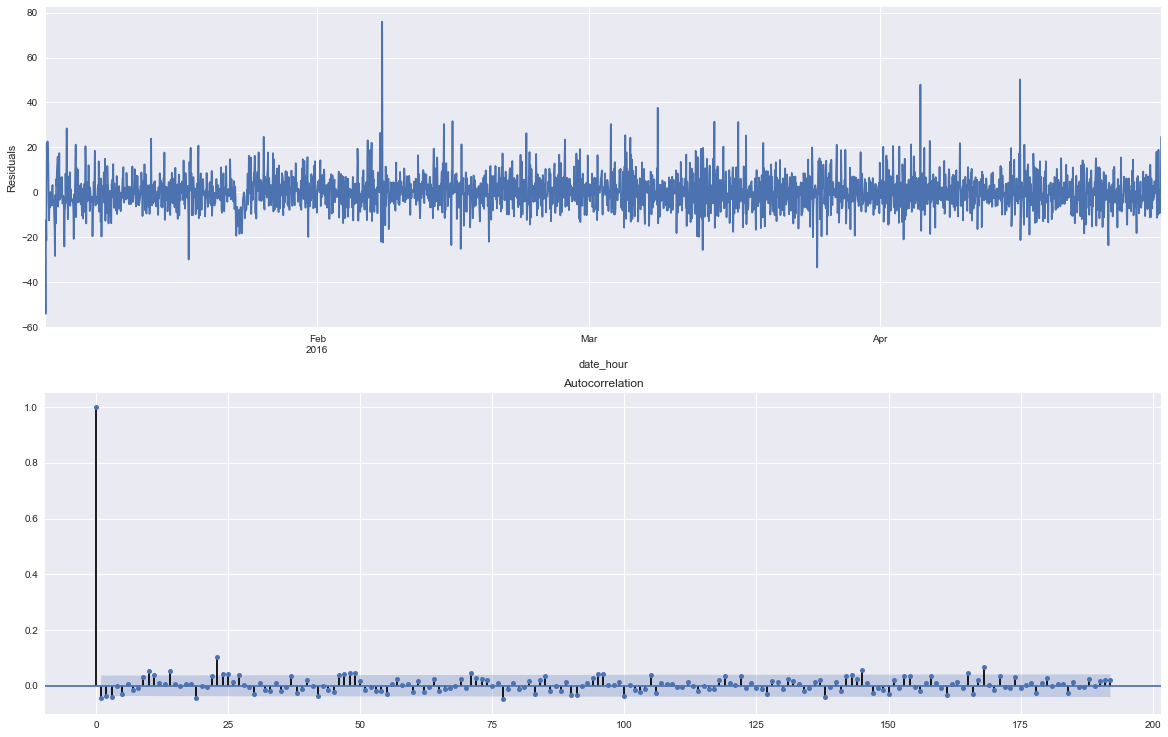

Критерий Стьюдента: p=0.395841
Критерий Дики-Фуллера: p=0.000000


In [36]:
f, (ax1, ax2) = plt.subplots(2, figsize=(20,13))
ax1 = plt.subplot(211)
best_model.resid[24:].plot()
plt.ylabel('Residuals')
ax2 = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[24:].values.squeeze(), lags=192, ax=ax2)
plt.show()

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[24:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[24:])[1])

## Кластер №3

Рассчитаем критерий Дики-Фуллера для остатков.

In [37]:
print 'Критерий Дики-Фуллера: p = {}'.format(sm.tsa.stattools.adfuller(resid.res3[:'2016-04-30'])[1])
print 'Критерий Дики-Фуллера (с сезонным дифференцированием): p = {}'.format(sm.tsa.stattools.adfuller(resid.res3_24[24:][:'2016-04-30'])[1])

Критерий Дики-Фуллера: p = 3.10883171733e-26
Критерий Дики-Фуллера (с сезонным дифференцированием): p = 0.0


Сделаем STL-декомпозицию остатков.

Populating the interactive namespace from numpy and matplotlib


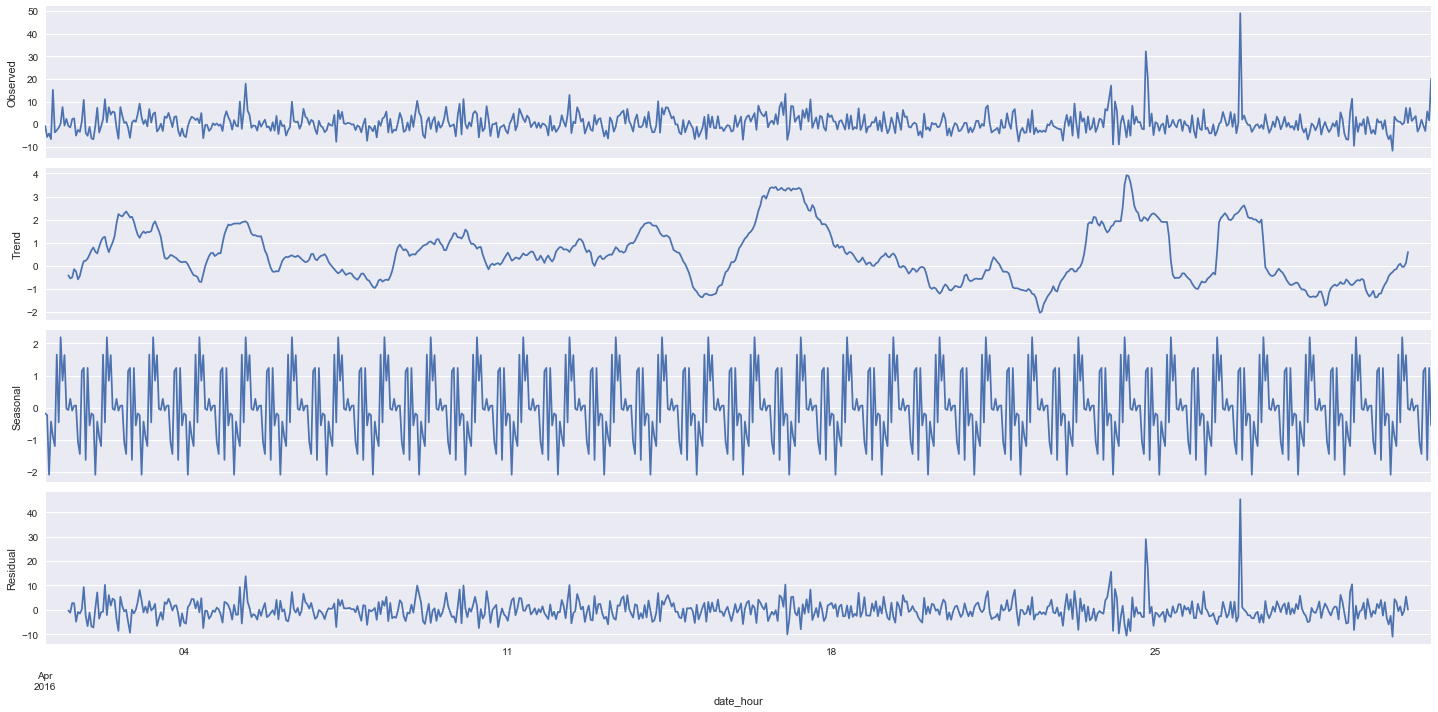

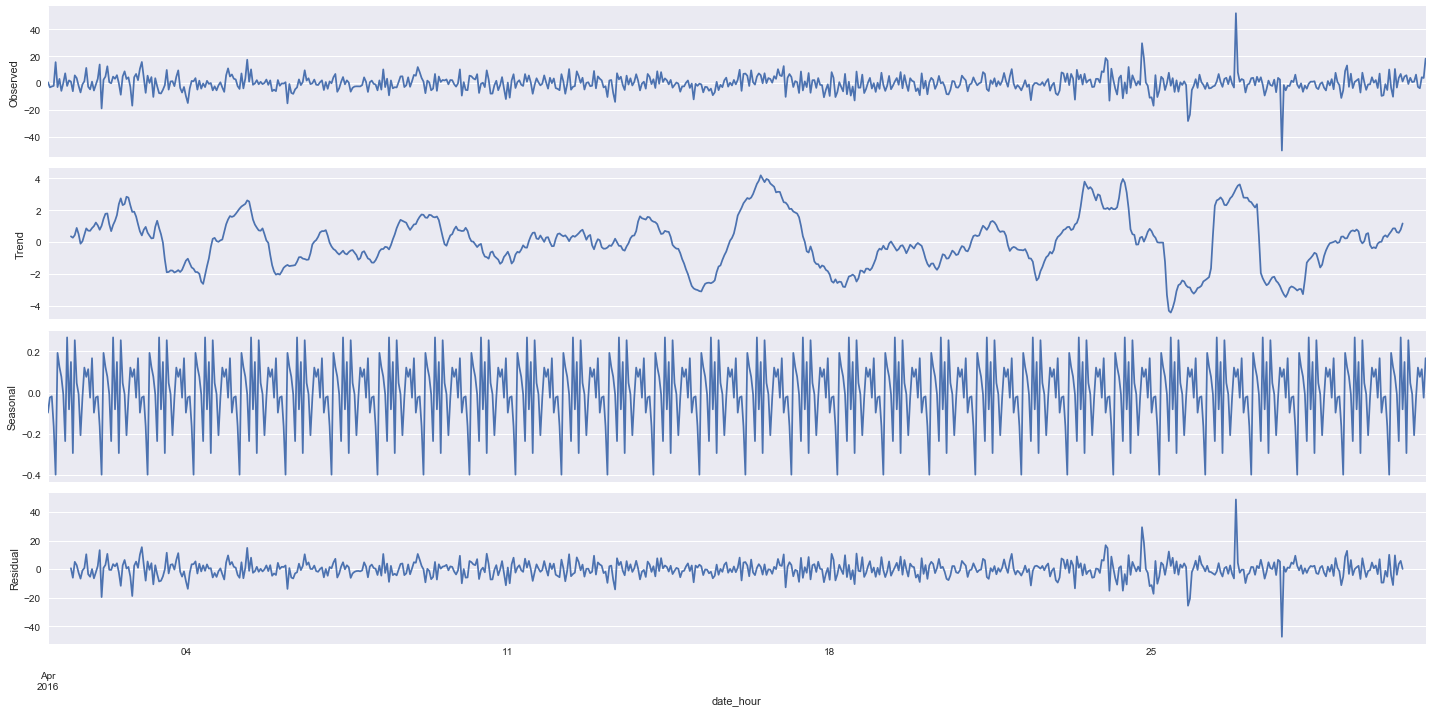

In [38]:
%pylab inline
plt.figure(figsize(20,10))
sm.tsa.seasonal_decompose(resid.res3['2016-04-01':'2016-04-30']).plot()  
sm.tsa.seasonal_decompose(resid.res3_24['2016-04-01':'2016-04-30']).plot()
pylab.show()

Построим ACF и PACF полученного ряда продифференцированных остатков.

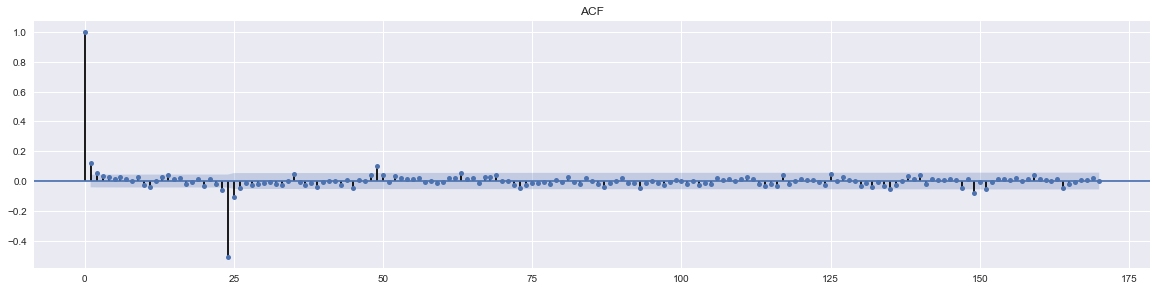

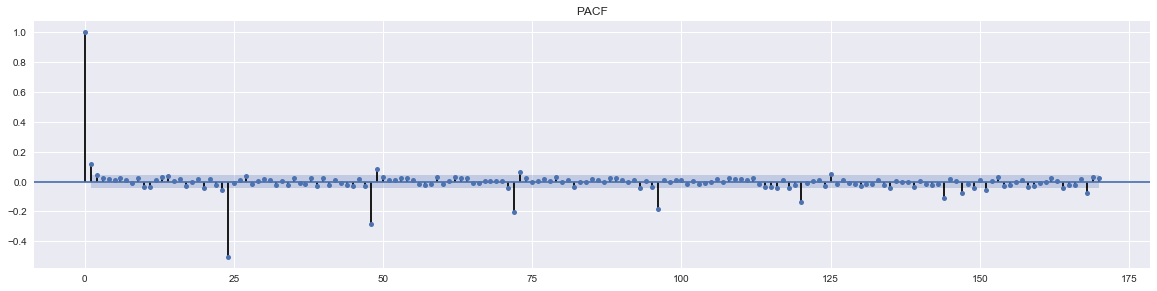

In [39]:
plt.figure(figsize(20,10))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(resid.res3_24['2016-02-01':'2016-04-30'].values.squeeze(), lags = 170, ax=ax, title = 'ACF')
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(resid.res3_24['2016-02-01':'2016-04-30'].values.squeeze(), lags = 170, ax=ax,title = 'PACF')
pylab.show()

In [40]:
ps = range(1, 3)
d = 0
qs = range(1, 3)

Ps = range(1, 3)
D = 1
Qs = range(1, 3)

s = 24

params = list(itertools.product(ps, qs, Ps, Qs))
print len(params)

16


Подберем лучшие гиперпараметры модели ARIMA для типичного ряда кластера №3. 

In [41]:
best_model = get_arima(resid.res3['2016-01-01':'2016-04-30'], params, d, D, s)

     parameters           aic
0  (1, 1, 1, 1)  17327.215385
4  (1, 2, 1, 1)  17327.365270
8  (2, 1, 1, 1)  17327.456285
2  (1, 1, 2, 1)  17329.169243
6  (1, 2, 2, 1)  17329.320512


Посмотрим на график остатков.

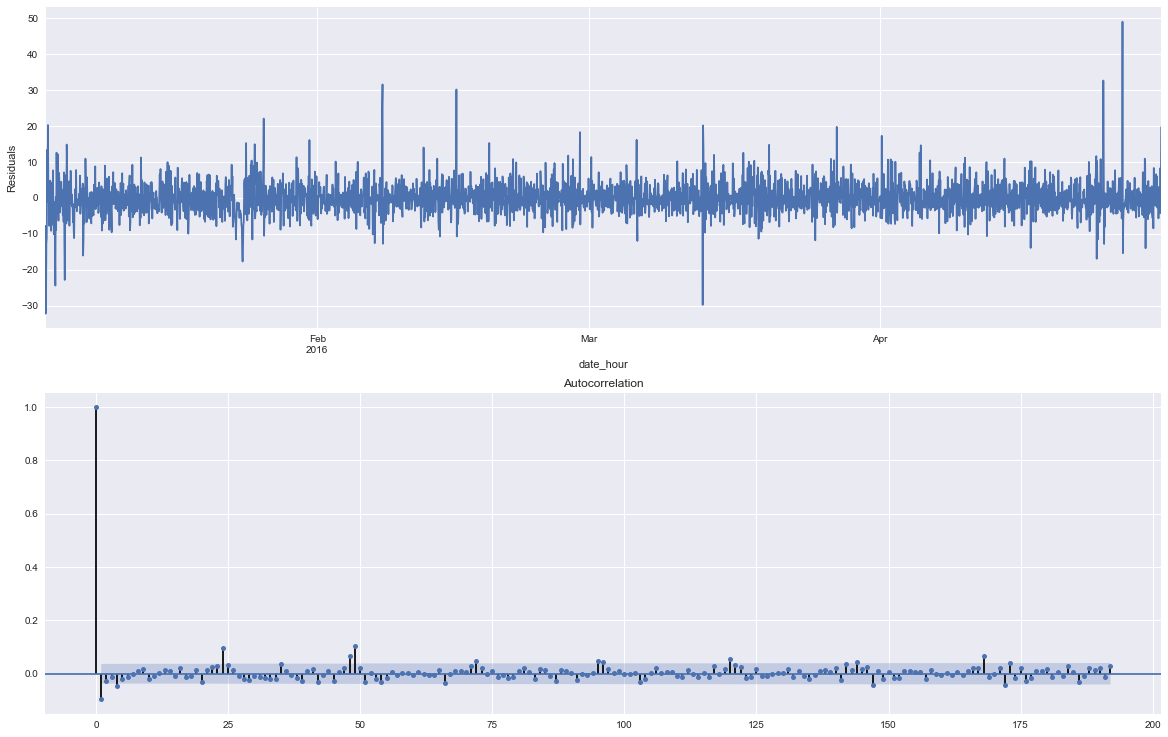

Критерий Стьюдента: p=0.306409
Критерий Дики-Фуллера: p=0.000000


In [42]:
f, (ax1, ax2) = plt.subplots(2, figsize=(20,13))
ax1 = plt.subplot(211)
best_model.resid[24:].plot()
plt.ylabel('Residuals')
ax2 = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[24:].values.squeeze(), lags=192, ax=ax2)
plt.show()

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[24:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[24:])[1])

## Кластер №4

Рассчитаем критерий Дики-Фуллера для остатков.

In [43]:
print 'Критерий Дики-Фуллера: p = {}'.format(sm.tsa.stattools.adfuller(resid.res4[:'2016-04-30'])[1])
print 'Критерий Дики-Фуллера (с сезонным дифференцированием): p = {}'.format(sm.tsa.stattools.adfuller(resid.res4_24[24:][:'2016-04-30'])[1])

Критерий Дики-Фуллера: p = 8.38926669174e-11
Критерий Дики-Фуллера (с сезонным дифференцированием): p = 5.53825942984e-28


Сделаем STL-декомпозицию остатков.

Populating the interactive namespace from numpy and matplotlib


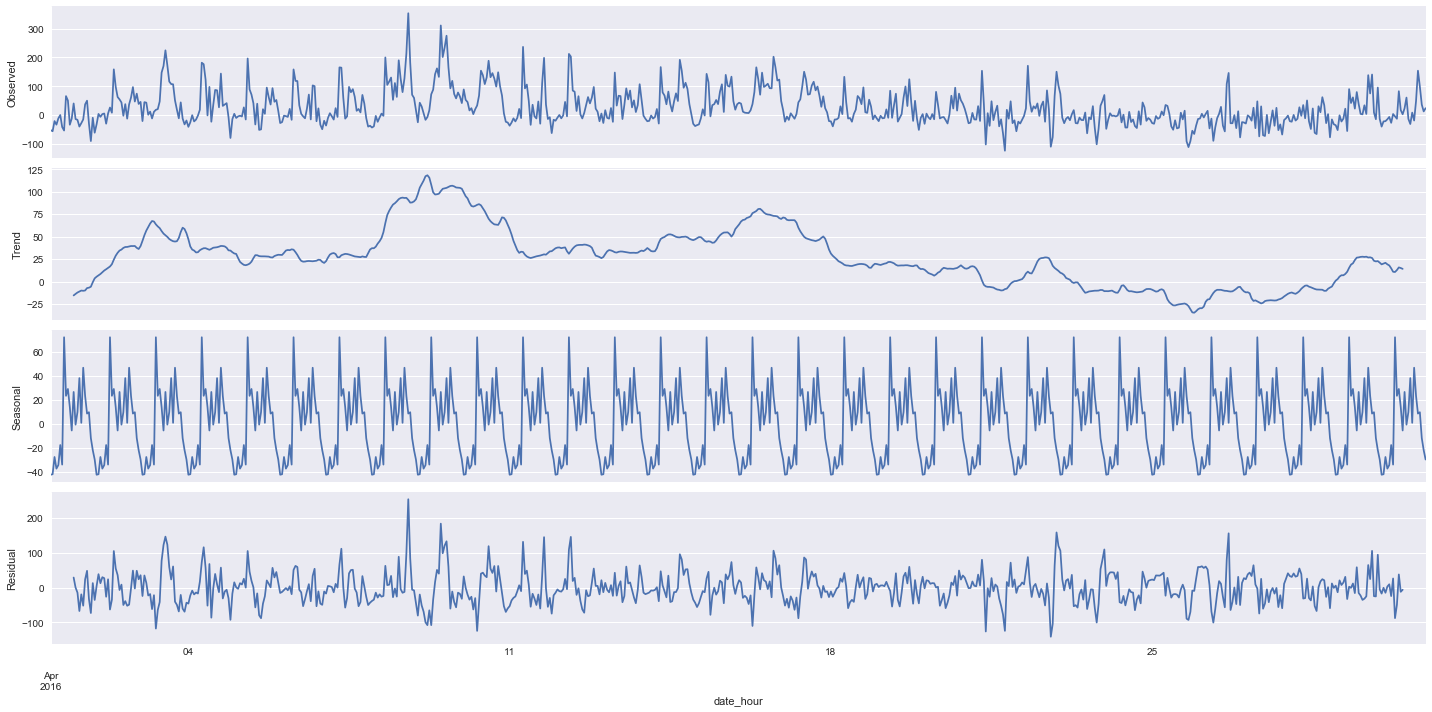

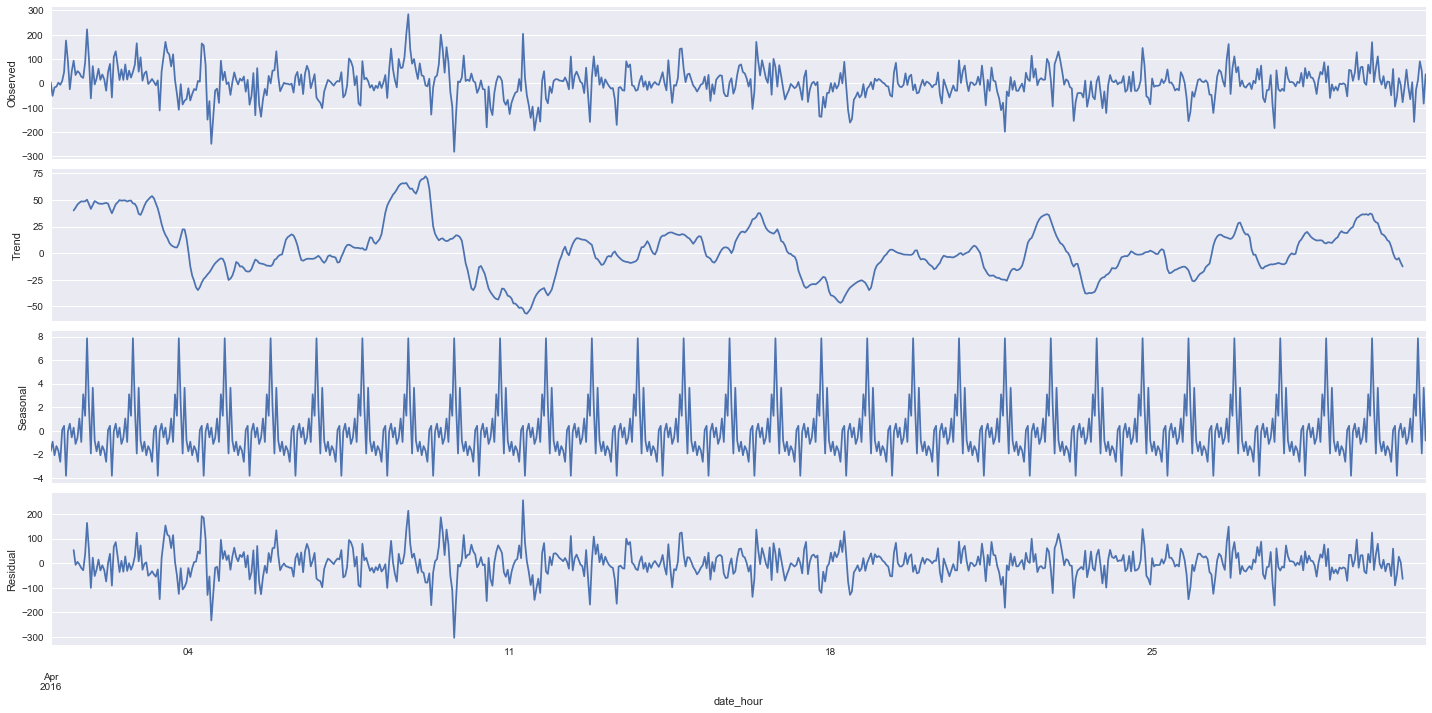

In [44]:
%pylab inline
plt.figure(figsize(20,10))
sm.tsa.seasonal_decompose(resid.res4['2016-04-01':'2016-04-30']).plot()  
sm.tsa.seasonal_decompose(resid.res4_24['2016-04-01':'2016-04-30']).plot()
pylab.show()

Построим ACF и PACF полученного ряда продифференцированных остатков.

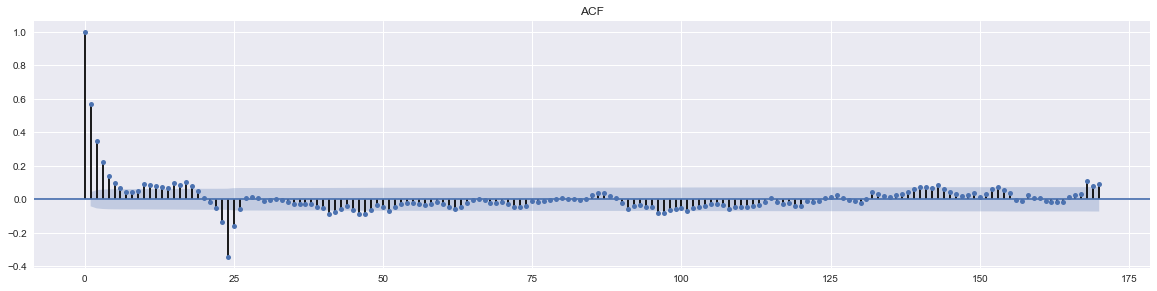

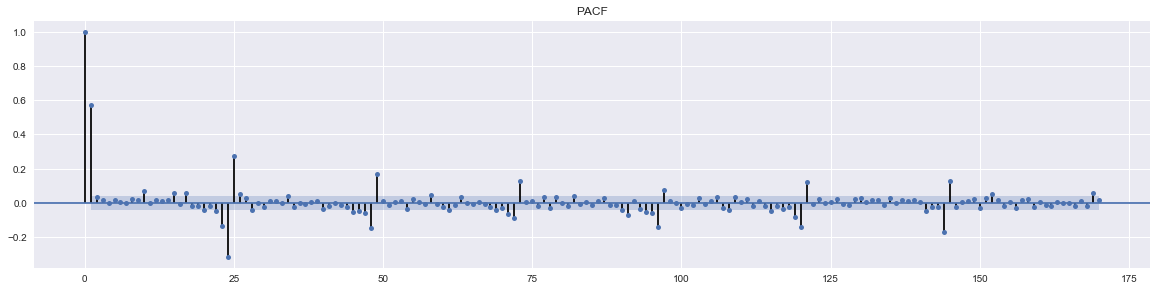

In [45]:
plt.figure(figsize(20,10))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(resid.res4_24['2016-02-01':'2016-04-30'].values.squeeze(), lags = 170, ax=ax, title = 'ACF')
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(resid.res4_24['2016-02-01':'2016-04-30'].values.squeeze(), lags = 170, ax=ax,title = 'PACF')
pylab.show()

In [46]:
ps = range(1, 3)
d = 0
qs = range(1, 3)

Ps = range(1, 3)
D = 1
Qs = range(1, 3)

s = 24

params = list(itertools.product(ps, qs, Ps, Qs))
print len(params)

16


Подберем лучшие гиперпараметры модели ARIMA для типичного ряда кластера №4. 

In [47]:
best_model = get_arima(resid.res4['2016-01-01':'2016-04-30'], params, d, D, s)

      parameters           aic
14  (2, 2, 2, 1)  31065.238895
10  (2, 1, 2, 1)  31065.611456
2   (1, 1, 2, 1)  31068.037304
12  (2, 2, 1, 1)  31068.824693
3   (1, 1, 2, 2)  31069.314536


Посмотрим на график остатков.

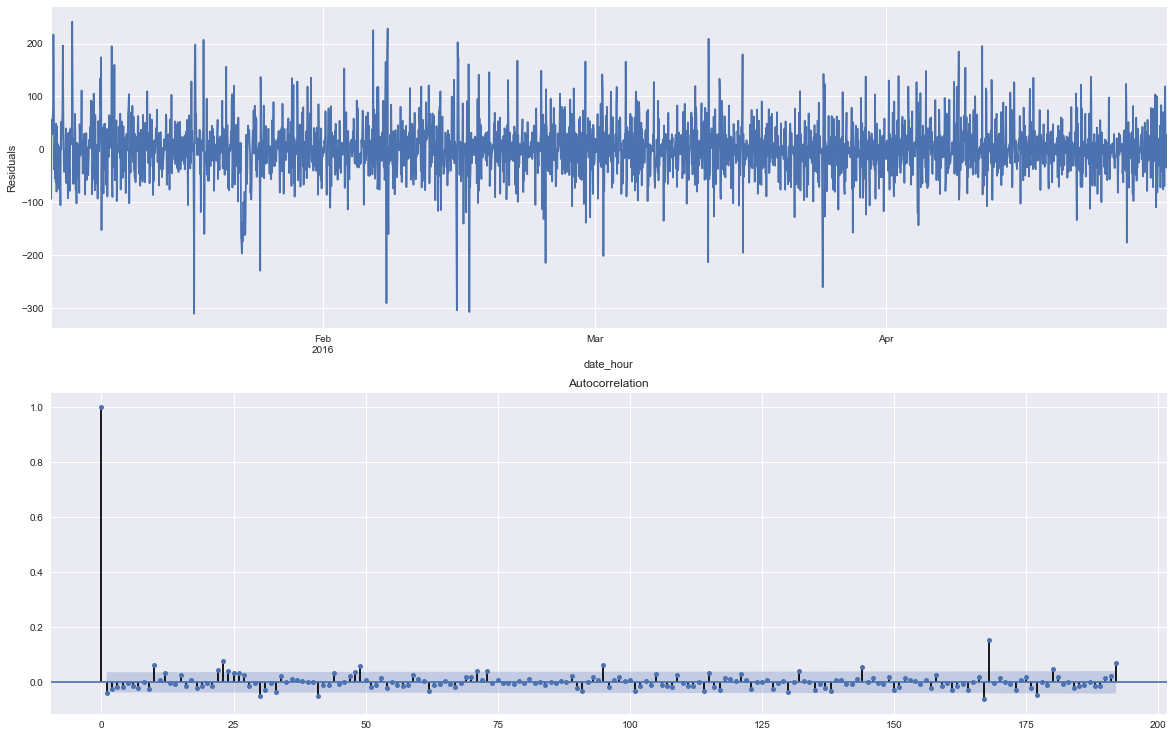

Критерий Стьюдента: p=0.667223
Критерий Дики-Фуллера: p=0.000000


In [48]:
f, (ax1, ax2) = plt.subplots(2, figsize=(20,13))
ax1 = plt.subplot(211)
best_model.resid[24:].plot()
plt.ylabel('Residuals')
ax2 = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[24:].values.squeeze(), lags=192, ax=ax2)
plt.show()

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[24:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[24:])[1])

## Кластер №5

Рассчитаем критерий Дики-Фуллера для остатков.

In [49]:
print 'Критерий Дики-Фуллера: p = {}'.format(sm.tsa.stattools.adfuller(resid.res5[:'2016-04-30'])[1])
print 'Критерий Дики-Фуллера (с сезонным дифференцированием): p = {}'.format(sm.tsa.stattools.adfuller(resid.res5_24[24:][:'2016-04-30'])[1])

Критерий Дики-Фуллера: p = 6.21323313435e-16
Критерий Дики-Фуллера (с сезонным дифференцированием): p = 9.0797588006e-28


Сделаем STL-декомпозицию остатков.

Populating the interactive namespace from numpy and matplotlib


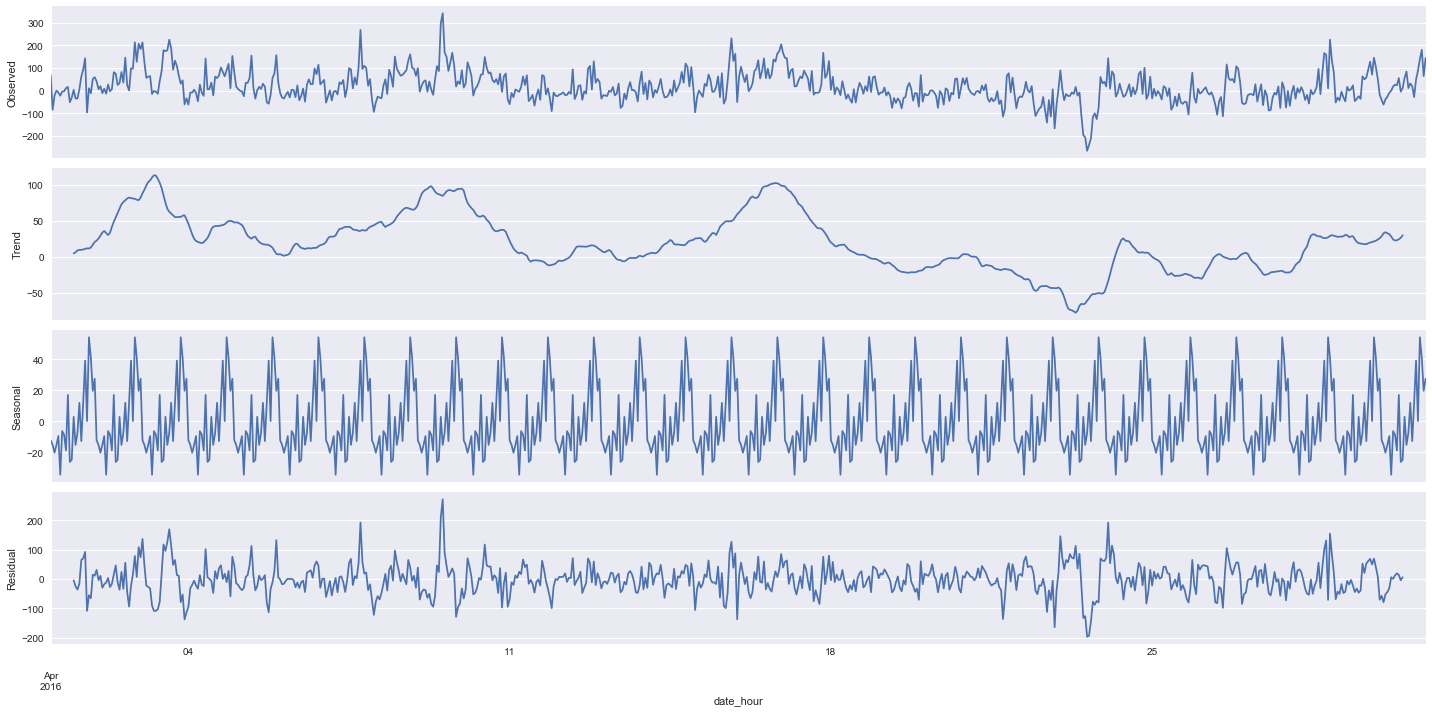

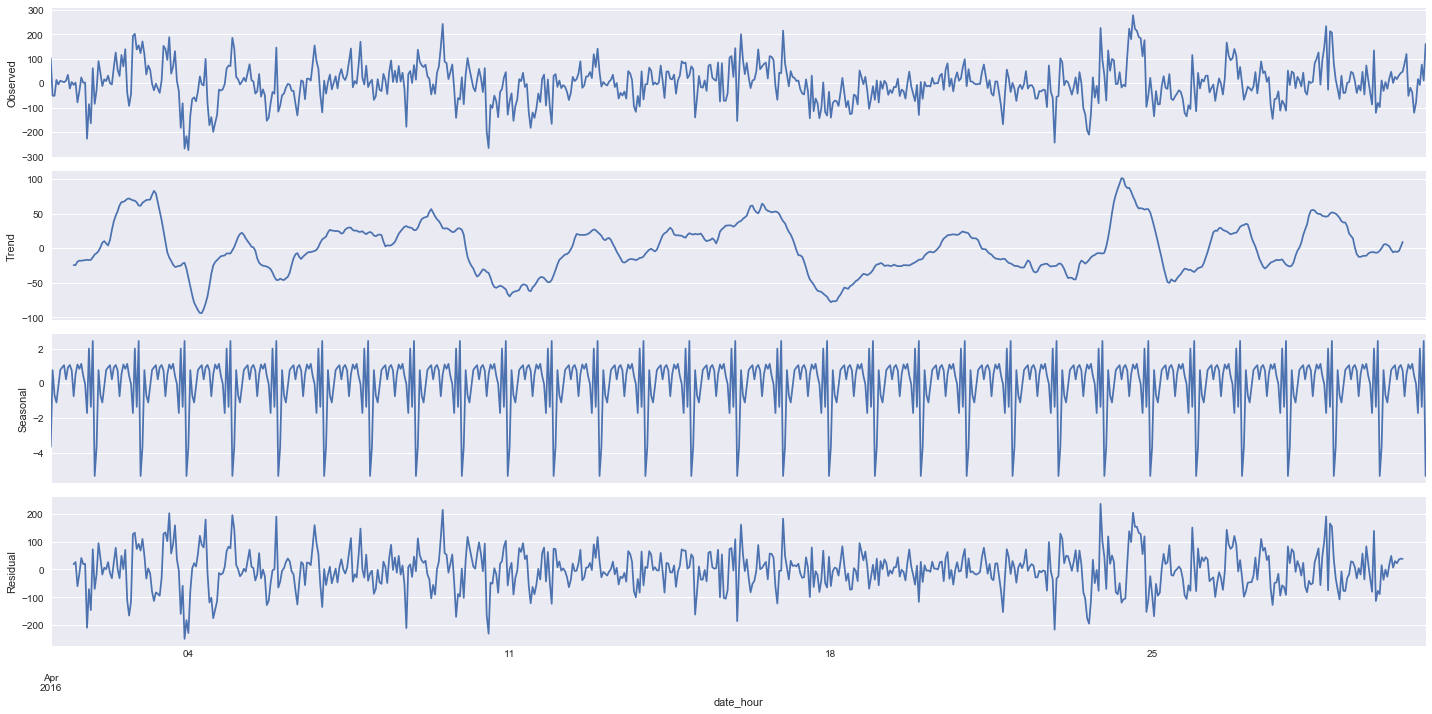

In [50]:
%pylab inline
plt.figure(figsize(20,10))
sm.tsa.seasonal_decompose(resid.res5['2016-04-01':'2016-04-30']).plot()  
sm.tsa.seasonal_decompose(resid.res5_24['2016-04-01':'2016-04-30']).plot()
pylab.show()

Построим ACF и PACF полученного ряда продифференцированных остатков.

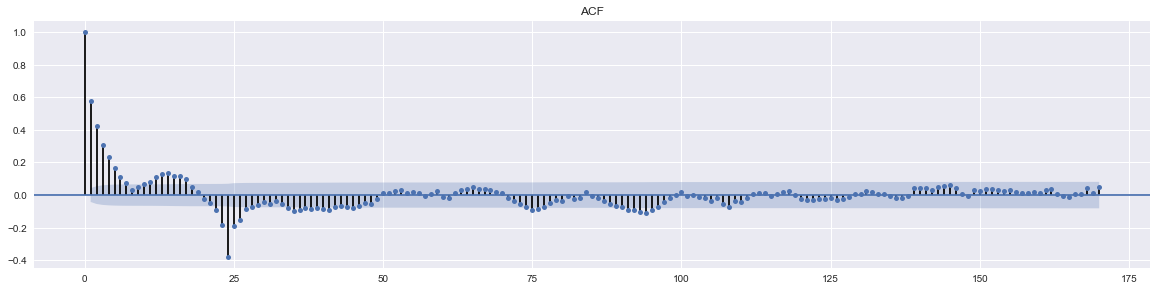

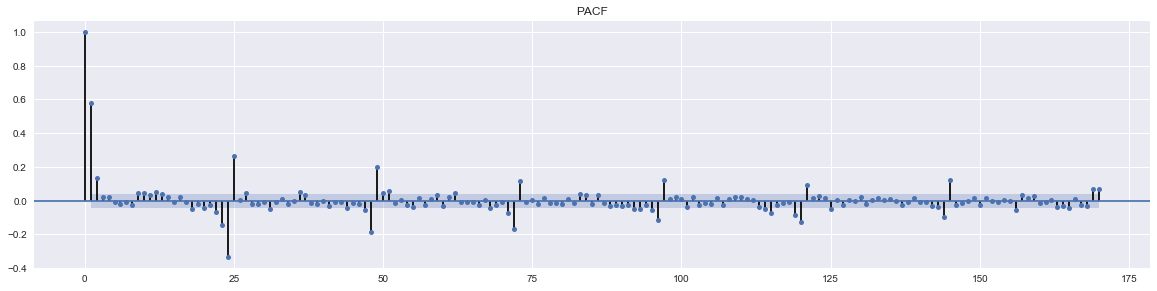

In [51]:
plt.figure(figsize(20,10))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(resid.res5_24['2016-02-01':'2016-04-30'].values.squeeze(), lags = 170, ax=ax, title = 'ACF')
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(resid.res5_24['2016-02-01':'2016-04-30'].values.squeeze(), lags = 170, ax=ax,title = 'PACF')
pylab.show()

In [52]:
ps = range(1, 3)
d = 0
qs = range(1, 3)

Ps = range(1, 3)
D = 1
Qs = range(1, 3)

s = 24

params = list(itertools.product(ps, qs, Ps, Qs))
print len(params)

16


Подберем лучшие гиперпараметры модели ARIMA для типичного ряда кластера №5. 

In [53]:
best_model = get_arima(resid.res5['2016-01-01':'2016-04-30'], params, d, D, s)

      parameters           aic
3   (1, 1, 2, 2)  31200.350073
9   (2, 1, 1, 2)  31200.370895
11  (2, 1, 2, 2)  31202.301215
7   (1, 2, 2, 2)  31202.424597
0   (1, 1, 1, 1)  31203.188683


Посмотрим на график остатков.

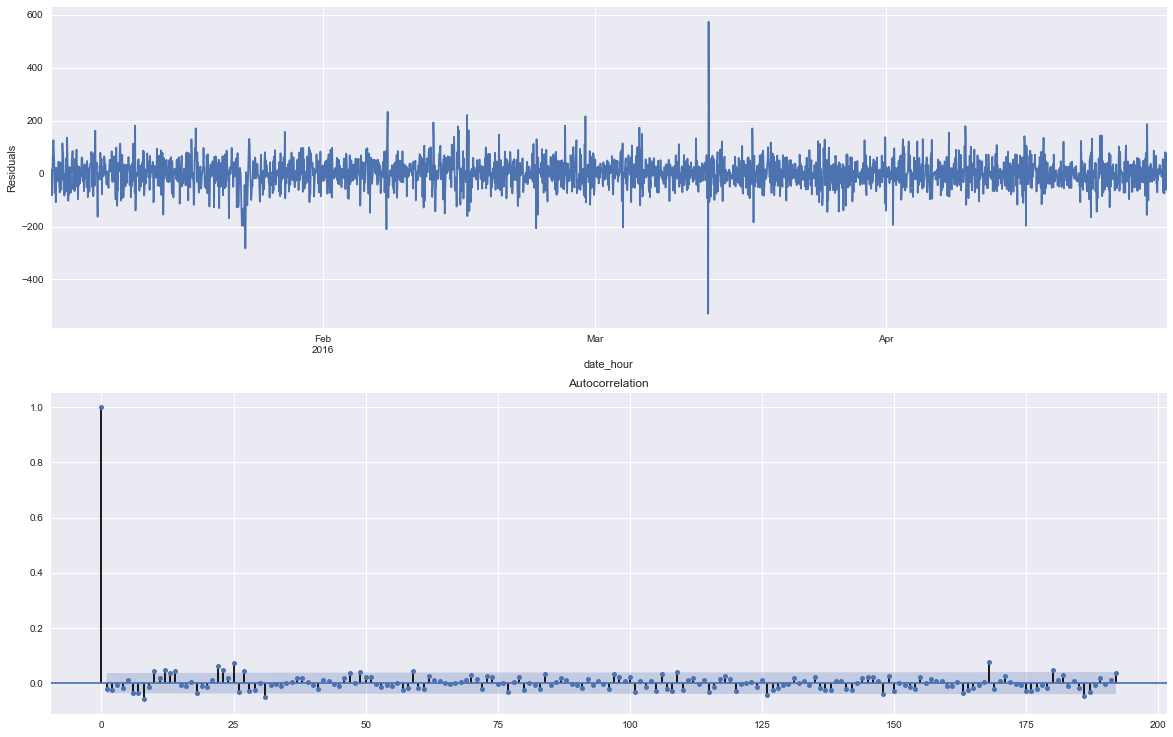

Критерий Стьюдента: p=0.170777
Критерий Дики-Фуллера: p=0.000000


In [54]:
f, (ax1, ax2) = plt.subplots(2, figsize=(20,13))
ax1 = plt.subplot(211)
best_model.resid[24:].plot()
plt.ylabel('Residuals')
ax2 = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[24:].values.squeeze(), lags=192, ax=ax2)
plt.show()

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[24:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[24:])[1])

 ## Прогноз на май

Для каждой из 102 географических зон настроим на данных до апреля 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны.
В процессе выполнения данного задания наткнулся на обсуждение на kaggle - https://inclass.kaggle.com/c/yellowtaxi/forums/t/27157/sarimax.
Для того чтобы не переобучать модель для предсказания на каждом часе применяется следущее решение. Обучаем модель на разрешенной выборки, cоздаем вторую модель на весь временной интервал выборки. Предсказывая нужный интервал в таком случае, устанавливаем параметр dynamic=True, это будет игнорировать все переданные исторические данные до момента времени, на котором мы делаем предсказание. То же самое если бы мы переобучали каждый раз и предсказывали без dynamic. 

Не все параметры наиболее типичных рядов каждого кластера подходят для других рядов данного кластера. Часто выскакивают исключения. В обработчике исключений я подбирал новые оптимальные параметры для этого региона. Так же было принято решение записывать результаты всех прогнозов в текстовый файл, чтобы не потерять их и иметь возможность воспользоваться ими в будущем. Код получился громоздким.

Зададим границы обучения и тестирования для мая.

In [57]:
start_train_time = '2016-01-01 00:00'
end_train_time = '2016-04-30 23:00'
start_test_time = '2016-04-30 23:00'
end_test_time = '2016-05-31 17:00'

In [18]:
f = lambda x: round(x, 0)
rnd = np.vectorize(f)

parameters = [(2, 1, 2, 2), 
              (2, 2, 2, 1), 
              (1, 1, 1, 1), 
              (1, 1, 1, 1), 
              (2, 2, 2, 1), 
              (1, 1, 2, 2)]

for i in range(k):

    regions = data_stand[i].columns

    for j in range(len(regions)):
        df = pd.DataFrame(index = data.index)
        df['series'] = data[i][regions[j]]

        y = df.series

        reg = Ridge()
        reg.fit(X[:end_train_time],y[:end_train_time])

        df['reg'] = reg.predict(X)
        df['resid'] = df['series'] - df['reg']

        param = parameters[i]
        try:
            print '{} region'.format(regions[j])
            start = datetime.now()

            model_res = sm.tsa.statespace.SARIMAX(df.resid[start_train_time:end_train_time], 
                                                  order=(param[0], 0, param[1]),
                                                  seasonal_order=(param[2], 1, param[3], 24), 
                                                  simple_differencing=True).fit(disp=-1)

            model_fitted = sm.tsa.statespace.SARIMAX(df.resid[start_train_time:end_test_time], 
                                                     order=(param[0], 0, param[1]), 
                                                     seasonal_order=(param[2], 1, param[3], 24),
                                                     simple_differencing=True).filter(model_res.params)

            predict = pd.DataFrame(index = data[start_test_time:end_test_time].index, columns=[1,2,3,4,5,6])
            error = pd.DataFrame(index = data[start_test_time:end_test_time].index, columns=[1,2,3,4,5,6])

            for time in error.index:    
                forecast = model_fitted.predict(time, time + relativedelta(hours=6), dynamic=True).values[1:]
                forecast += df[time+relativedelta(hours=1):time + relativedelta(hours=6)].reg.values
                forecast[forecast < 0.0] = 0
                forecast = rnd(forecast)
                forecast = forecast.astype(int)

                predict.loc[time] = forecast
                error.loc[time] = df[time+relativedelta(hours=1):time + relativedelta(hours=6)].series.values - forecast
            
            predict.to_csv('forecasts_may/predict_{}.csv'.format(str(regions[j])))
            error.to_csv('forecasts_may/error_{}.csv'.format(str(regions[j])))
        
            print '{0} region is predicted: {1}'.format(regions[j], datetime.now() - start)
            
        except Exception as ex:
            print type(ex)     
        
            start = datetime.now()

            ps = range(0, 2)
            d = 0
            qs = range(0, 2)
            Ps = range(0, 2)
            D = 1
            Qs = range(0, 2)
            s = 24
            params = list(itertools.product(ps, qs, Ps, Qs))

            best_aic = float('inf')
            warnings.filterwarnings('ignore')

            for param in params:

                try:
                    model_res = sm.tsa.statespace.SARIMAX(df.resid[start_train_time:end_train_time], 
                                                          order=(param[0], 0, param[1]),
                                                          seasonal_order=(param[2], 1, param[3], 24), 
                                                          simple_differencing=True).fit(disp=-1)

                except ValueError:
                    continue
                except LinAlgError:
                    continue
                aic = model_res.aic

                if aic < best_aic:
                    best_model = model_res
                    best_aic = aic
                    best_param = param

            warnings.filterwarnings('default')
            print best_param
            
            model_fitted = sm.tsa.statespace.SARIMAX(df.resid[start_train_time:end_test_time], 
                                                     order=(best_param[0], 0, best_param[1]), 
                                                     seasonal_order=(best_param[2], 1, best_param[3], 24),
                                                     simple_differencing=True).filter(model_res.params)
            
            predict = pd.DataFrame(index = data[start_test_time:end_test_time].index, columns=[1,2,3,4,5,6])
            error = pd.DataFrame(index = data[start_test_time:end_test_time].index, columns=[1,2,3,4,5,6])

            for time in error.index:
                forecast = model_fitted.predict(time, time + relativedelta(hours=6), dynamic=True).values[1:]
                forecast += df[time+relativedelta(hours=1):time + relativedelta(hours=6)].reg.values
                forecast[forecast < 0.0] = 0
                forecast = rnd(forecast)
                forecast = forecast.astype(int)

                predict.loc[time] = forecast
                error.loc[time] = df[time+relativedelta(hours=1):time + relativedelta(hours=6)].series.values - forecast

            predict.to_csv('forecasts_may/predict_{}.csv'.format(str(regions[j])))
            error.to_csv('forecasts_may/error_{}.csv'.format(str(regions[j])))

            print '{0} region is predicted: {1}'.format(regions[j], datetime.now() - start)

1382 region
1382 region is predicted: 0:06:25.903000
1684 region
<type 'exceptions.ValueError'>
(1, 1, 1, 1)
1684 region is predicted: 0:01:41.081000
1733 region


C:\ProgramData\Anaconda2\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1733 region is predicted: 0:07:19.449000
1734 region
1734 region is predicted: 0:07:06.528000
1783 region
1783 region is predicted: 0:07:00.107000
2068 region
2068 region is predicted: 0:07:20.686000
2069 region
<type 'exceptions.ValueError'>
(1, 0, 1, 1)
2069 region is predicted: 0:00:55.304000
2118 region
2118 region is predicted: 0:07:21.674000
2119 region
<type 'exceptions.ValueError'>
(1, 0, 1, 1)
2119 region is predicted: 0:01:20.130000
2168 region
2168 region is predicted: 0:07:22.488000
1129 region
1129 region is predicted: 0:07:07.089000
1130 region
1130 region is predicted: 0:07:08.221000
1176 region
1176 region is predicted: 0:06:28.888000
1177 region


C:\ProgramData\Anaconda2\lib\site-packages\statsmodels\tsa\statespace\tools.py:405: RuntimeWarning: invalid value encountered in sqrt
  x = r / ((1 - r**2)**0.5)
C:\ProgramData\Anaconda2\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1368: RuntimeWarning: invalid value encountered in double_scalars
  constrained[start] = unconstrained[start]**2


<type 'exceptions.ValueError'>
(1, 1, 1, 1)
1177 region is predicted: 0:01:55.690000
1178 region
1178 region is predicted: 0:07:23.984000
1221 region
<type 'exceptions.ValueError'>
(1, 1, 0, 1)
1221 region is predicted: 0:01:12.677000
1222 region
1222 region is predicted: 0:07:21.624000
1223 region
1223 region is predicted: 0:07:13.260000
1227 region
1227 region is predicted: 0:05:51.515000
1228 region
1228 region is predicted: 0:07:03.207000
1272 region
1272 region is predicted: 0:07:12.075000
1273 region
1273 region is predicted: 0:06:14.740000
1274 region
<type 'exceptions.ValueError'>
(1, 1, 0, 1)
1274 region is predicted: 0:01:10.378000
1326 region
1326 region is predicted: 0:07:10.370000
1327 region
<type 'exceptions.ValueError'>
(1, 1, 0, 1)
1327 region is predicted: 0:01:19.948000
1376 region
1376 region is predicted: 0:06:26.530000
1377 region
<type 'exceptions.ValueError'>
(1, 1, 0, 1)
1377 region is predicted: 0:01:10.861000
1378 region
1378 region is predicted: 0:06:49.6890

## Рассчет ошибки прогноза

In [55]:
regions = []

for i in all_regions:
    regions.append(pd.read_csv('forecasts_may/error_{}.csv'.format(i), parse_dates=True, header=0))

In [60]:
error = pd.concat(regions)
error = error[error.date_hour >= start_test_time]

In [59]:
error = error.iloc[:,1:].values
Q = np.sum(np.abs(error))/float(102 * 739 * 6)
print Q

27.8287696675


## Прогноз на июнь

Зададим границы обучения и тестирования для июня.

In [61]:
start_train_time = '2016-01-01 00:00'
end_train_time = '2016-05-31 23:00'
start_test_time = '2016-05-31 23:00'
end_test_time = '2016-06-30 17:00'

Прогноз на июнь выполнен по аналогии с маем.

In [22]:
f = lambda x: round(x, 0)
rnd = np.vectorize(f)

parameters = [(2, 1, 2, 2), 
              (2, 2, 2, 1), 
              (1, 1, 1, 1), 
              (1, 1, 1, 1), 
              (2, 2, 2, 1), 
              (1, 1, 2, 2)]

for i in range(k):

    regions = data_stand[i].columns

    for j in range(len(regions)):
        df = pd.DataFrame(index = data.index)
        df['series'] = data[i][regions[j]]

        y = df.series

        reg = Ridge()
        reg.fit(X[:end_train_time],y[:end_train_time])

        df['reg'] = reg.predict(X)
        df['resid'] = df['series'] - df['reg']

        param = parameters[i]
        try:
            print '{} region'.format(regions[j])
            start = datetime.now()

            model_res = sm.tsa.statespace.SARIMAX(df.resid[start_train_time:end_train_time], 
                                                  order=(param[0], 0, param[1]),
                                                  seasonal_order=(param[2], 1, param[3], 24), 
                                                  simple_differencing=True).fit(disp=-1)

            model_fitted = sm.tsa.statespace.SARIMAX(df.resid[start_train_time:end_test_time], 
                                                     order=(param[0], 0, param[1]), 
                                                     seasonal_order=(param[2], 1, param[3], 24),
                                                     simple_differencing=True).filter(model_res.params)

            predict = pd.DataFrame(columns=['id','y'])

            for time in df[start_test_time:end_test_time].index:    
                forecast = model_fitted.predict(time, time + relativedelta(hours=6), dynamic=True).values[1:]
                forecast += df[time+relativedelta(hours=1):time + relativedelta(hours=6)].reg.values
                forecast[forecast < 0.0] = 0
                forecast = rnd(forecast)
                forecast = forecast.astype(int)

                region = [regions[j]] * 6
                date = [time.date()] * 6
                hour = [time.hour] * 6
                hour_pred = range(1,7)
                forecast_id = []
                for z in zip(region, date, hour, hour_pred):
                    forecast_id.append('{0}_{1}_{2}_{3}'.format(z[0],z[1],z[2],z[3]))
                    
                d = {'id': forecast_id, 'y': forecast}
                predict = pd.concat([predict, pd.DataFrame.from_dict(d)])
            
            predict.to_csv('forecasts_june/predict_{}.csv'.format(str(regions[j])), index=False)
        
            print '{0} region is predicted: {1}'.format(regions[j], datetime.now() - start)
            
        except Exception as ex:
            print type(ex)     
        
            start = datetime.now()

            ps = range(0, 2)
            d = 0
            qs = range(0, 2)
            Ps = range(0, 2)
            D = 1
            Qs = range(0, 2)
            s = 24
            params = list(itertools.product(ps, qs, Ps, Qs))

            best_aic = float('inf')
            warnings.filterwarnings('ignore')

            for param in params:

                try:
                    model_res = sm.tsa.statespace.SARIMAX(df.resid[start_train_time:end_train_time], 
                                                          order=(param[0], 0, param[1]),
                                                          seasonal_order=(param[2], 1, param[3], 24), 
                                                          simple_differencing=True).fit(disp=-1)

                except ValueError:
                    continue
                except LinAlgError:
                    continue
                aic = model_res.aic

                if aic < best_aic:
                    best_model = model_res
                    best_aic = aic
                    best_param = param

            warnings.filterwarnings('default')
            print best_param
            
            model_fitted = sm.tsa.statespace.SARIMAX(df.resid[start_train_time:end_test_time], 
                                                     order=(best_param[0], 0, best_param[1]), 
                                                     seasonal_order=(best_param[2], 1, best_param[3], 24),
                                                     simple_differencing=True).filter(model_res.params)
            
            predict = pd.DataFrame(columns=['id','y'])

            for time in df[start_test_time:end_test_time].index: 
                forecast = model_fitted.predict(time, time + relativedelta(hours=6), dynamic=True).values[1:]
                forecast += df[time+relativedelta(hours=1):time + relativedelta(hours=6)].reg.values
                forecast[forecast < 0.0] = 0
                forecast = rnd(forecast)
                forecast = forecast.astype(int)

                region = [regions[j]] * 6
                date = [time.date()] * 6
                hour = [time.hour] * 6
                hour_pred = range(1,7)
                forecast_id = []
                for z in zip(region, date, hour, hour_pred):
                    forecast_id.append('{0}_{1}_{2}_{3}'.format(z[0],z[1],z[2],z[3]))
                    
                d = {'id': forecast_id, 'y': forecast}
                predict = pd.concat([predict, pd.DataFrame.from_dict(d)])
            
            predict.to_csv('forecasts_june/predict_{}.csv'.format(str(regions[j])), index=False)

            print '{0} region is predicted: {1}'.format(regions[j], datetime.now() - start)

1382 region
1382 region is predicted: 0:07:25.386000
1684 region
1684 region is predicted: 0:06:52.372000
1733 region
1733 region is predicted: 0:08:38.535000
1734 region
1734 region is predicted: 0:08:53.239000
1783 region
1783 region is predicted: 0:09:02.855000
2068 region
<type 'exceptions.ValueError'>
(1, 1, 1, 1)
2068 region is predicted: 0:02:06.653000
2069 region
<type 'exceptions.ValueError'>
(1, 1, 1, 1)
2069 region is predicted: 0:01:18.393000
2118 region
2118 region is predicted: 0:08:52.795000
2119 region
<type 'exceptions.ValueError'>
(1, 0, 1, 1)
2119 region is predicted: 0:01:38.829000
2168 region
2168 region is predicted: 0:09:16.511000
1129 region
1129 region is predicted: 0:07:38.630000
1130 region
1130 region is predicted: 0:07:28.460000
1176 region
1176 region is predicted: 0:08:28.513000
1177 region
1177 region is predicted: 0:07:25.590000
1178 region
1178 region is predicted: 0:08:33.870000
1221 region
<type 'exceptions.ValueError'>
(1, 1, 0, 1)
1221 region is pr

C:\ProgramData\Anaconda2\lib\site-packages\statsmodels\tsa\statespace\tools.py:405: RuntimeWarning: invalid value encountered in sqrt
  x = r / ((1 - r**2)**0.5)
C:\ProgramData\Anaconda2\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1368: RuntimeWarning: invalid value encountered in double_scalars
  constrained[start] = unconstrained[start]**2


<type 'exceptions.ValueError'>
(1, 1, 1, 1)
1234 region is predicted: 0:02:21.483000
1235 region
1235 region is predicted: 0:08:32.239000
1279 region
<type 'exceptions.ValueError'>
(1, 1, 1, 1)
1279 region is predicted: 0:02:00.171000
1280 region
1280 region is predicted: 0:07:07.728000
1283 region
1283 region is predicted: 0:08:09.531000
1284 region
1284 region is predicted: 0:07:35.674000
1285 region
1285 region is predicted: 0:07:57.319000
1286 region
1286 region is predicted: 0:07:07.726000
1287 region
1287 region is predicted: 0:09:07.848000
1331 region
1331 region is predicted: 0:07:15.953000
1332 region
1332 region is predicted: 0:07:25.534000
1333 region
1333 region is predicted: 0:07:54.419000
1334 region
1334 region is predicted: 0:08:51.655000
1335 region
1335 region is predicted: 0:08:29.815000
1336 region
1336 region is predicted: 0:06:44.787000
1337 region
<type 'exceptions.ValueError'>
(1, 1, 1, 1)
1337 region is predicted: 0:02:05.830000
1338 region
1338 region is predi

Запишем полученный прогноз на июнь в текстовый файл.

In [62]:
regions = []

for i in all_regions:
    regions.append(pd.read_csv('forecasts_june/predict_{}.csv'.format(i), header=0))

june_forecast = pd.concat(regions)
june_forecast.to_csv('forecasts_june/forecast.csv', index=False)

Полученная ошибка 25.98364. Ссылка на сабмишн: https://inclass.kaggle.com/c/yellowtaxi/leaderboard?submissionId=5048639. Имя на kaggle T800.